# Import packages

In [1]:
#!pip install packagename
# importing modules
import geopandas as gpd
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import os
from os import chdir as cd
import time
import fiona
from datetime import date

# Places and Cities are synonymously used here

# Join shapefiles for all places to create one master file for the whole US

In [2]:
# # Exporting all shapefiles for plotting
# # Importing the places shapefiles for all states
# # combining them into one for further use
# from pathlib import Path
# # define the file location
# folder = Path(r"D:\Work\Box Sync\Trends_all states\Maps_2020\\")
# # reading the zip file
# shapefiles = folder.glob("tl_2020_*_place.zip")
# # combining places for US into one file
# gdf = pd.concat([gpd.read_file(shp) for shp in shapefiles]).pipe(gpd.GeoDataFrame)
# gdf = gdf.set_crs("EPSG:4269")
# gdf.to_file(folder / 'compiled.shp')

# Import all spatial data / vector data (shapefiles) for analysis

In [3]:
US_places = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\compiled.shp')
US_counties = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2020_us_county.zip')
US_states = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2020_us_state.zip') 

# source: https://gis.stackexchange.com/questions/141580/which-projection-is-best-for-mapping-the-contiguous-united-states
US_states = US_states.to_crs('EPSG:9311')
US_places = US_places.to_crs('EPSG:9311')
US_counties = US_counties.to_crs('EPSG:9311')

US_places.shape, US_counties.shape, US_states.shape

((32188, 17), (3234, 18), (56, 15))

# Import Census population data at Place (city) level 

In [29]:
census_pop = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Population_DP05\DECENNIALPL2020.P1-Data.csv', header = 1)
census_pop[['Geography', 'Geographic Area Name', ' !!Total:',]]
census_pop['GEOID'] = census_pop['Geography'].str.slice(-7)
census_pop['CensusPop_20'] = census_pop[' !!Total:']
census_pop.shape

(31909, 147)

# Merging Places' spatial data with Census population

In [30]:
places_with_population = US_places.merge(census_pop[['GEOID', 'CensusPop_20']] , on = 'GEOID', how = 'outer')

In [31]:
places_with_population.shape

(32188, 18)

# Import Current Population Trend

In [32]:
# Current population trend output found from PopDecCensus.ipynb gives current trend for all places in the US
# the places that had trend identified is only listed in this file
places_attr = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\current_trend_from_census.csv', dtype = {'GEOID':str, 'STATEFP':str})
places_attr['STATEFP'] = places_attr['GEOID'].str[:2]
places_attr.head()

,STATEFP,GEOID,NAME_2020,P_2000,P_2010,P_2020,total_changeRate,mean_changeRate,sign_2000_2010,sign_2010_2020,sign_2000_2020,change_Rate,%annual_10_20,annual_change,trend2,density_km2
0,01,0102260,"Ardmore town, Alabama",1034.0,1194.0,1321.0,0.277563,0.013055,1.0,1.0,1.0,"(0.1, 0.5]",0.010637,"[0.01, 0.05)",6 moderately increasing,249.721403
1,01,0151264,"Mooresville town, Alabama",59.0,53.0,47.0,-0.203390,-0.010745,-1.0,-1.0,-1.0,"(-0.5, -0.1]",-0.011321,"[-0.05, -0.01)",2 moderately depopulating,72.716358
2,01,0171496,"Somerville town, Alabama",347.0,724.0,796.0,1.293948,0.059295,1.0,1.0,1.0,"(0.0, 0.1]",0.009945,"[0.0, 0.01)",5 slowly increasing,89.481747
3,01,0176872,"Trinity town, Alabama",1841.0,2095.0,2526.0,0.372080,0.017185,1.0,1.0,1.0,"(0.1, 0.5]",0.020573,"[0.01, 0.05)",6 moderately increasing,196.398215
4,01,0130880,"Goshen town, Alabama",300.0,266.0,269.0,-0.103333,-0.005103,-1.0,1.0,-1.0,"(0.0, 0.1]",0.001128,"[0.0, 0.01)",4 fluctuating,40.544753


In [13]:
# places_attr.isna().sum()

In [33]:
places_attr['State'] = places_attr['STATEFP']
places_attr['label'] = places_attr['trend2']

print(f'Shape of the places_attr dataframe: {places_attr.shape}')

Shape of the places_attr dataframe: (31675, 18)


In [34]:
# Check number of values found from estimation
print('Current population trend for cities in the US (50 States with District of Columbia): \n')
print('Current Trend                No of cities')
print(places_attr['label'].value_counts())
print('\n')
print('Percent cities with different population trends: \n')
places_attr['label'].value_counts()/ places_attr['label'].value_counts().sum()

Current population trend for cities in the US (50 States with District of Columbia): 

Current Trend                No of cities
label
3 slowly depopulating        5721
5 slowly increasing          5509
2 moderately depopulating    4569
4 fluctuating                4136
6 moderately increasing      3626
7 highly increasing           575
1 severely depopulating       159
Name: count, dtype: int64


Percent cities with different population trends: 



label
3 slowly depopulating        0.235481
5 slowly increasing          0.226754
2 moderately depopulating    0.188063
4 fluctuating                0.170241
6 moderately increasing      0.149249
7 highly increasing          0.023667
1 severely depopulating      0.006545
Name: count, dtype: float64

# Join attributes with 2020 Census population vector data

In [35]:
# joining tabular data with spatial data by merging the data files based on column name
# use 'outer' join and check unmatched datanames
places_merged_all = places_with_population.merge(places_attr.loc[:,['GEOID', 'trend2', 'label', 'State']],
                                    on = 'GEOID', 
                                    how = 'outer', 
                                    indicator=True)

In [37]:
places_merged_all.shape, places_merged_all.columns, places_attr.shape, places_with_population.shape

((32246, 22),
 Index(['STATEFP', 'PLACEFP', 'PLACENS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
        'CLASSFP', 'PCICBSA', 'PCINECTA', 'MTFCC', 'FUNCSTAT', 'ALAND',
        'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'CensusPop_20', 'trend2',
        'label', 'State', '_merge'],
       dtype='object'),
 (31675, 18),
 (32188, 18))

In [38]:
print('Places that exist in the geographic file (US_places) but not in population data')
# these are places that changed NAME, GEOID or Both or merged or dropped
places_merged_all[places_merged_all['_merge'] == 'left_only'].sort_values('NAME').groupby(['STATEFP']).agg({'GEOID':'count',
                                                                                                            'CensusPop_20':'sum',
                                                                                                           }).sum()

Places that exist in the geographic file (US_places) but not in population data


GEOID               571.0
CensusPop_20    1861648.0
dtype: float64

In [39]:
# excluding NaN values for census population since that will result in non-numeric population factor
places_merged = places_merged_all[places_merged_all['CensusPop_20'].notnull()] 
print(f'Dataframe after drop null values in CensusPop_20 column: {places_merged.shape}\n')

# Excluding Puerto Rico since Hauer's forecast do not have values for Puerto Rico
places_merged = places_merged[places_merged['STATEFP'] != '72']
print(f'Final dataframe for analysis: {places_merged.shape} \n')

places_merged[['STATEFP','GEOID', 'NAMELSAD','ALAND','CensusPop_20','label',]].head()

Dataframe after drop null values in CensusPop_20 column: (31909, 22)

Final dataframe for analysis: (31617, 22) 



,STATEFP,GEOID,NAMELSAD,ALAND,CensusPop_20,label
0,01,0102260,Ardmore town,5289895.0,1321.0,6 moderately increasing
1,01,0151264,Mooresville town,646347.0,47.0,2 moderately depopulating
2,01,0171496,Somerville town,8895669.0,796.0,5 slowly increasing
3,01,0176872,Trinity town,12861624.0,2526.0,6 moderately increasing
4,01,0130880,Goshen town,6634644.0,269.0,4 fluctuating


Not everyone resides in a place; in 1990, approximately 66 million people (26 percent) in the United States lived outside of any place, \
either in small settlements, in the open countryside, or in the densely settled fringe of large cities in areas that were built-up, \
but not identifiable as places. 

In [40]:
# # As of the census, 26% of the people in the United States lived outside of places
# # Checking if the percent value matches with/ is close to total US population
places_merged['CensusPop_20'].sum()/(1-0.26), places_merged.shape

(337506962.1621622, (31617, 22))

# Import County level population count from Census

In [41]:
county_population = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\County Population\DECENNIALPL2020.P1-Data.csv', header = 1)
county_population.shape, county_population[' !!Total:'].sum()

county_population['Total population'] = county_population[' !!Total:'].astype('float')
county_population['GEOID10'] = county_population['Geography'].str.slice(-5)

# Loading forecasted population data from Hauer

In [42]:
# loading forecasted population data from Hauer
%cd "D:\Work\Box Sync\Trends_all states\HauersProjection\county_projectios_Total_bySex_byRace\total_pop_proj"
county_Projection = gpd.read_file(r"hauer_county_totpop_SSPs.shp")

# contains 3221 rows, 3135 rows contains forecast values, these 3135 rows will be used for analysis
print(county_Projection.shape)

# 78 rows with zero data for counties in Puerto Rico 
# check coordinate system and project to similar coordinate system
# to change the coordinate system
county_Projection = county_Projection.to_crs('3528')
if county_Projection.crs != places_merged.crs:
    places_merged = places_merged.to_crs(county_Projection.crs)

places_merged.shape

D:\Work\Box Sync\Trends_all states\HauersProjection\county_projectios_Total_bySex_byRace\total_pop_proj
(3221, 104)


(31617, 22)

In [43]:
# merging projection data with county level census population
county_with_population = county_Projection.merge(county_population[['GEOID10', 'Geographic Area Name', 'Total population']],
                                                 on = 'GEOID10', 
                                                 how = 'outer', 
                                                 indicator = True)

In [45]:
print(county_with_population['Total population'].dtypes)

# some places have changed their name or spelling but the area haven't changed
# To address those values Manual correction
county_with_population.loc[625,105] = 9719.0    # On January 2, 2019, it was abolished and replaced by the Chugach Census Area and the Copper River Census Area
county_with_population.loc[2754,105] = 13672.0  # Oglala Lakota County (known as Shannon County until May 2015
county_with_population.loc[173,105] = 8368      # Kusilvak Census Area, formerly known as Wade Hampton Census Area
# Excluding puerto Rico
county_with_population = county_with_population[county_with_population['STATEFP10'] != '72']
# Dropping NAN values
county_with_population.dropna(subset=['STATEFP10'], inplace=True)

float64


In [46]:
# NOT USING IT IN ANY RESULTS
df_P_20_with_margin = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\Population_2020_with_margin.csv', 
                                  index_col = 0)
df_P_20_with_margin['GEOID'] = df_P_20_with_margin['GEO_ID'].str.slice(-7)

In [47]:
places_merged[places_merged['STATEFP'] == '17'].shape
county_with_population['STATEFP10'].sort_values().unique()

array(['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48',
       '49', '50', '51', '53', '54', '55', '56'], dtype=object)

# Distributing Hauer's county level forecast to city level

In [50]:
# A combined dataframe is created to distribute the county level forecast from Hauer's data to Plcaes/ Cities
# The county population is distributed based on population weights

combined_df = pd.DataFrame()
gdf = pd.DataFrame()

for state in county_with_population['STATEFP10'].sort_values().unique():
    # print('start...')
    # print('........')
    population_projection =  county_with_population[county_with_population['STATEFP10'] == state]
    places_population = places_merged[places_merged['STATEFP'] == state]
    
    # print(population_projection.head())
    # print('........')
    # print(places_population.head())
    
    if population_projection.crs == places_population.crs:
        # calculating total area from geometry # try using land/water ratio???? # didnt use geom_area, used ALAND area
        geom_overlayed = gpd.overlay(population_projection, places_population, how='intersection', keep_geom_type=False, make_valid=True)
        print(geom_overlayed.shape)

        geom_overlayed['intersect_area'] = geom_overlayed.area
    
        geom_overlayed['%area'] = geom_overlayed['intersect_area'] /geom_overlayed['ALAND'] 
        area_factor = pd.DataFrame()
        area_factor[['GEOID', 'COUNTY', 'area_factor']] = geom_overlayed.groupby(by = ['GEOID'])['%area'].apply(lambda x:(x/x.sum())).reset_index()
        geom_overlayed = geom_overlayed.merge(area_factor[['GEOID', 'area_factor']], on = 'GEOID')
        geom_overlayed['landarea'] = geom_overlayed['ALAND'] / (1000*1000)
        # density in km2
        geom_overlayed['density'] = geom_overlayed['CensusPop_20']/geom_overlayed['landarea'] # 'P_20'
        geom_overlayed['P_20_adjusted'] = geom_overlayed['area_factor'] * geom_overlayed['density'] * geom_overlayed['landarea']
        # what percent of county population lives in this place
        geom_overlayed['population_factor'] = geom_overlayed['P_20_adjusted'] / geom_overlayed['Total population'] #.apply(lambda x:(x/x.sum()))
    
        # geom_overlayed['population_factor'] = geom_overlayed.groupby(by = ['STATEFP', 'NAMELSAD10'])['P_20_adjusted'].apply(lambda x:(x/x.sum()))
        geom_overlayed['population_factor'] = geom_overlayed['population_factor'].fillna(0)
        # normalizing population factor so that county total becomes 1
        # geom_overlayed['population_factor'] = geom_overlayed.groupby(by = ['STATEFP10', 'NAMELSAD10'])['population_factor'].apply(lambda x:(x/x.sum()))
        # print(geom_overlayed.shape)
        print(geom_overlayed.columns[18], geom_overlayed.columns[102])
        for colidx in range(18,103):                # columns that contains county sums
            column_name =  'forecast_' + str(geom_overlayed.columns[colidx])
            geom_overlayed[column_name] = (geom_overlayed.iloc[:,colidx] * geom_overlayed['population_factor']).round(0)
        
        # gdf is used to make the plot
        # gdf contains ungrouped data by GEOID
        gdf = pd.concat([gdf, geom_overlayed])

        print(geom_overlayed.columns[136], geom_overlayed.columns[220])    
        column_name = geom_overlayed.columns[136:221] # taking the columns that have forecasted dataset
        print('for check: State ' + state + '  column name ' + column_name[0] + ' ' + column_name[-1])
        forecasted_df = pd.DataFrame()
        forecasted_df = geom_overlayed.groupby(by = ['GEOID', 'CensusPop_20'], as_index=False)[column_name].apply(lambda x:(x.sum()))

        county_names = geom_overlayed.groupby(by = ['GEOID'], as_index=False).agg({'COUNTYFP10': 'first', 'NAME10': 'count'})
        forecasted_df =  forecasted_df.merge(county_names, on = 'GEOID')
    
    
        df_with_MOE = forecasted_df.merge(df_P_20_with_margin[df_P_20_with_margin['GEOID'].str.startswith(state)][['P_20_upper', 
                                                                                                               'P_20_lower','NAME', 'GEOID',]], on = 'GEOID')
    
        df_with_MOE['MOE'] = (df_with_MOE['P_20_upper']- df_with_MOE['P_20_lower'])/2
        df_with_MOE['diff'] = (df_with_MOE['P_20_upper']- df_with_MOE['MOE']- df_with_MOE['forecast_ssp32020'])
        df_with_MOE['diff'] = df_with_MOE['diff'].replace(-np.inf, np.nan)
        # print('Completed for state: ' + state)

        combined_df = pd.concat([combined_df, df_with_MOE])
    else:
        print('check coordinate system')
    

(755, 129)
ssp12020 ssp52100
forecast_ssp12020 forecast_ssp52100
for check: State 01  column name forecast_ssp12020 forecast_ssp52100
(382, 129)
ssp12020 ssp52100
forecast_ssp12020 forecast_ssp52100
for check: State 02  column name forecast_ssp12020 forecast_ssp52100
(514, 129)
ssp12020 ssp52100
forecast_ssp12020 forecast_ssp52100
for check: State 04  column name forecast_ssp12020 forecast_ssp52100
(708, 129)
ssp12020 ssp52100
forecast_ssp12020 forecast_ssp52100
for check: State 05  column name forecast_ssp12020 forecast_ssp52100
(1869, 129)
ssp12020 ssp52100
forecast_ssp12020 forecast_ssp52100
for check: State 06  column name forecast_ssp12020 forecast_ssp52100
(585, 129)
ssp12020 ssp52100
forecast_ssp12020 forecast_ssp52100
for check: State 08  column name forecast_ssp12020 forecast_ssp52100
(250, 129)
ssp12020 ssp52100
forecast_ssp12020 forecast_ssp52100
for check: State 09  column name forecast_ssp12020 forecast_ssp52100
(82, 129)
ssp12020 ssp52100
forecast_ssp12020 forecast_ssp521

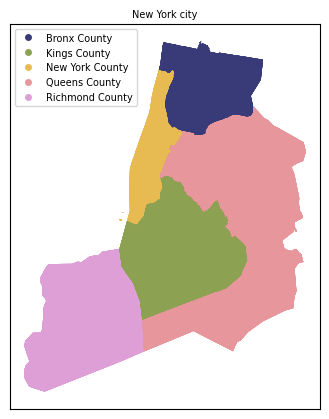

In [26]:
# =====================================================
# # Some cities are part of multiple counties, find the city that is overlaped by maximum counties
# =====================================================
city_name = 'New York city'
plotting_city = gdf[(gdf['NAMELSAD'] ==city_name) & (gdf['%area'] > 0.001)]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 5))
plotting_city.plot(ax= ax, column = 'NAMELSAD10', legend = True, 
                   cmap = 'tab20b', legend_kwds={'loc': 'upper left','fontsize': 7,
                                                'markerscale' : 0.5})
ax.set_title(str(city_name), fontsize=7, pad=5)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
# fig.savefig(r'D:\Work\Box Sync\NC Figures\\' + str(city_name) + '.pdf', dpi =300, bbox_inches='tight')


In [51]:
# Combined_df is obtained by distributing Hauer's county level forecast
df_Hauer = combined_df.reset_index(drop= True).copy()

# Import NCAR city level aggregated (1km grid level is converted to city level) data as csv

In [52]:
# This dataset is derived using raster to vector conversion analyzed and saved from 0 SSPGeotiff2Population.ipynb and 0 merge_agg_NCAR_pop.ipynb
pop_from_NCAR = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Spatial_Population_geotiff\Population from SSP\r_concat_SSP\NCAR_agg_scenarios.csv',
                            index_col = 0, dtype = {'GEOID_ssp5': str})

df_NCAR = pop_from_NCAR.copy()

# Merging both forecasts (Hauer's and NCAR)

In [53]:
print('Cells with zero population count in 2020 for scenario SSP 4: ')
print('From NCAR:---'), print(df_NCAR[df_NCAR['population_2020_ssp4'] == 0].shape[0])
print('From Hauer:---'), print(df_Hauer[df_Hauer['forecast_ssp42020'] == 0].shape[0])
print(df_NCAR.shape, df_Hauer.shape,)

Cells with zero population count in 2020 for scenario SSP 4: 
From NCAR:---
172
From Hauer:---
114
(32188, 160) (31616, 94)


In [54]:
# MERGING TWO DATASETS
right_on_column_name = 'GEOID_ssp5'
df_both_combined = df_Hauer.merge(df_NCAR, left_on = 'GEOID', right_on = right_on_column_name, how = 'outer', indicator = True )
# df_both_combined.columns, 
df_both_combined.shape

(32188, 255)

In [57]:
df_both_combined[df_both_combined['_merge'] == 'left_only'].shape, \
df_both_combined[df_both_combined['_merge'] == 'right_only'].shape, \
df_both_combined[df_both_combined['_merge'] == 'both'].shape, 

((0, 255), (572, 255), (31616, 255))

In [58]:
# Common to both dataframes
df_complete = df_both_combined[df_both_combined['_merge'] == 'both'].reset_index(drop=True)
print('No of cities common to both datasets: ' + str(df_complete.shape[0]))

No of cities common to both datasets: 31616


In [99]:
df_complete[['CensusPop_20', 'forecast_ssp12020', 'population_2020_ssp1', 'forecast_ssp22020', 'population_2020_ssp']]

,CensusPop_20,forecast_ssp12020,population_2020_ssp1,forecast_ssp22020,population_2020_ssp2
0,133.0,268.0,120.862785,266.0,120.108070
1,2358.0,2376.0,3117.207520,2366.0,3103.677246
2,4366.0,4328.0,6717.400391,4316.0,6699.276367
3,659.0,654.0,572.227905,652.0,569.781311
4,225.0,222.0,228.789917,221.0,227.910919
...,...,...,...,...,...
31611,118.0,130.0,57.418358,129.0,57.418358
31612,4773.0,5111.0,4139.469727,5089.0,4130.321289
31613,1644.0,1864.0,171.304642,1862.0,171.304642
31614,131.0,146.0,67.785461,146.0,67.785461


# Error in forecast when compared with 2020 census population

In [61]:
# diff of error terms: https://www.baeldung.com/cs/mape-vs-wape-vs-wmape
# ======================================================================

df_MAPE = df_complete.copy()

print(df_MAPE.shape)


# MEAN ABSOLUTE PERCENT ERROR
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def calculate_mape(df, actual_col, predict_col):
    return round(MAPE(df[actual_col], df[predict_col]), 2)

# MAPE < 10 is considered good forecast from the source below
# https://www.researchgate.net/publication/257812432_Using_the_R-MAPE_index_as_a_resistant_measure_of_forecast_accuracy/citations

error_from_hauer_mape = [calculate_mape(df_MAPE, 'CensusPop_20', 'forecast_ssp12020'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'forecast_ssp22020'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'forecast_ssp32020'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'forecast_ssp42020'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'forecast_ssp52020')]

error_from_NCAR_mape = [calculate_mape(df_MAPE, 'CensusPop_20', 'population_2020_ssp1'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'population_2020_ssp2'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'population_2020_ssp3'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'population_2020_ssp4'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'population_2020_ssp5')]

# print('\n')
# print('Mean absolute percent error for Hauer and NCAR respectively:---')
# print(error_from_hauer, error_from_NCAR)

# WEIGHTED ABSOLUTE PERCENT ERROR (WAPE)
#Defining MAPE function
def WAPE(Y_actual,Y_Predicted):
    wape = np.sum(np.abs(Y_actual - Y_Predicted)) *100/np.sum(Y_actual)
    return wape

def calculate_wape(df, actual_col, predict_col):
    return WAPE(df[actual_col], df[predict_col]).round(2)


error_from_hauer_wape = [calculate_wape(df_MAPE, 'CensusPop_20', 'forecast_ssp12020'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'forecast_ssp22020'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'forecast_ssp32020'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'forecast_ssp42020'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'forecast_ssp52020')]

error_from_NCAR_wape = [calculate_wape(df_MAPE, 'CensusPop_20', 'population_2020_ssp1'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'population_2020_ssp2'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'population_2020_ssp3'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'population_2020_ssp4'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'population_2020_ssp5')]

# print('\n')
# print('Weighted absolute percent error for Hauer and NCAR respectively:---')
# print(error_from_hauer, error_from_NCAR)

# WEIGHTED MEAN ABSOLUTE PERCENT ERROR (WMAPE)
#Defining WMAPE function
def WMAPE(Y_actual,Y_Predicted, weights):
    wmape = np.sum(np.abs(Y_actual - Y_Predicted)* weights) *100/np.sum(Y_actual*weights)
    return wmape

def calculate_wmape(df, actual_col, predict_col, weight_col):
    return WMAPE(df[actual_col], df_MAPE[predict_col], df_MAPE[weight_col]).round(2)

df_MAPE['normalized_pop']= (df_MAPE['CensusPop_20'] - df_MAPE['CensusPop_20'].min())/(df_MAPE['CensusPop_20'].max()-df_MAPE['CensusPop_20'].min())

error_from_hauer_wmape = [calculate_wmape(df_MAPE, 'CensusPop_20', 'forecast_ssp12020', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20', 'forecast_ssp22020', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20', 'forecast_ssp32020', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20', 'forecast_ssp42020', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20', 'forecast_ssp52020', 'normalized_pop')]

error_from_NCAR_wmape = [calculate_wmape(df_MAPE, 'CensusPop_20', 'population_2020_ssp1', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20','population_2020_ssp2', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20','population_2020_ssp3', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20','population_2020_ssp4', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20','population_2020_ssp5', 'normalized_pop')]



(31616, 255)


Text(0.5, 1.0, 'Absolute Percent Errors \n (weighted by population)')

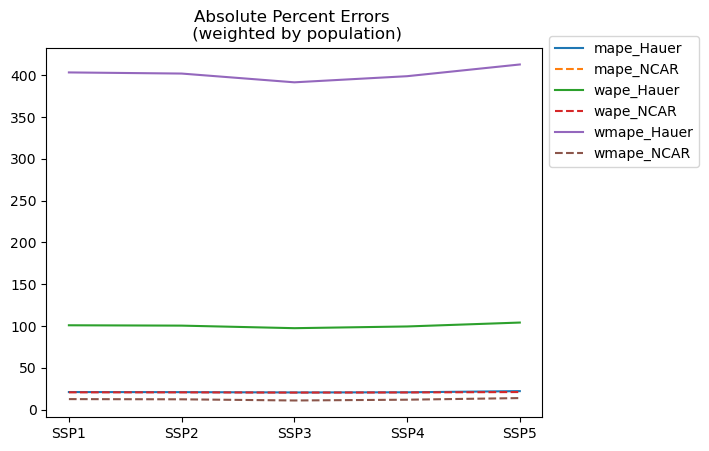

In [100]:
error_values_hauer1 = error_from_hauer_mape
error_values_NCAR1 = error_from_NCAR_mape
error_values_hauer2 = error_from_hauer_wape
error_values_NCAR2 = error_from_NCAR_wape
error_values_hauer2 = error_from_hauer_wape
error_values_NCAR2 = error_from_NCAR_wape
error_values_hauer3 = error_from_hauer_wmape
error_values_NCAR3 = error_from_NCAR_wmape

plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_hauer1, label="mape_Hauer")
plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_NCAR1, '--', label="mape_NCAR")
plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_hauer2, label="wape_Hauer")
plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_NCAR2, '--', label="wape_NCAR")
plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_hauer3, label="wmape_Hauer")
plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_NCAR3, '--', label="wmape_NCAR")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.title('Absolute Percent Errors \n (weighted by population)')

Since Hauer's data over predict and NCAR underpredict we use an weighted average of these two for three scenarios: SSP 1, SSP 2 and SSP 4. \
We dropped 3 and 5 since 5 shows an insanely high pattern and the baseline conditions that is huge dependence on fossil fuel is not possible. \
SSP 3 shows an rapid decreasing rate in population, which is no way align with current population trend.

# Forecasting Trend in population from 2020-2100

<Axes: >

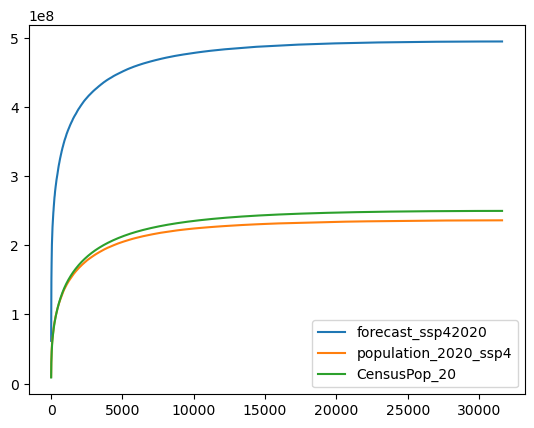

In [63]:
df_cumsum = df_complete[['forecast_ssp42020','population_2020_ssp4','CensusPop_20']].sort_values(by= 'CensusPop_20', 
                                                                                                 ascending = False).reset_index(drop= True)
df_cumsum.cumsum().plot()

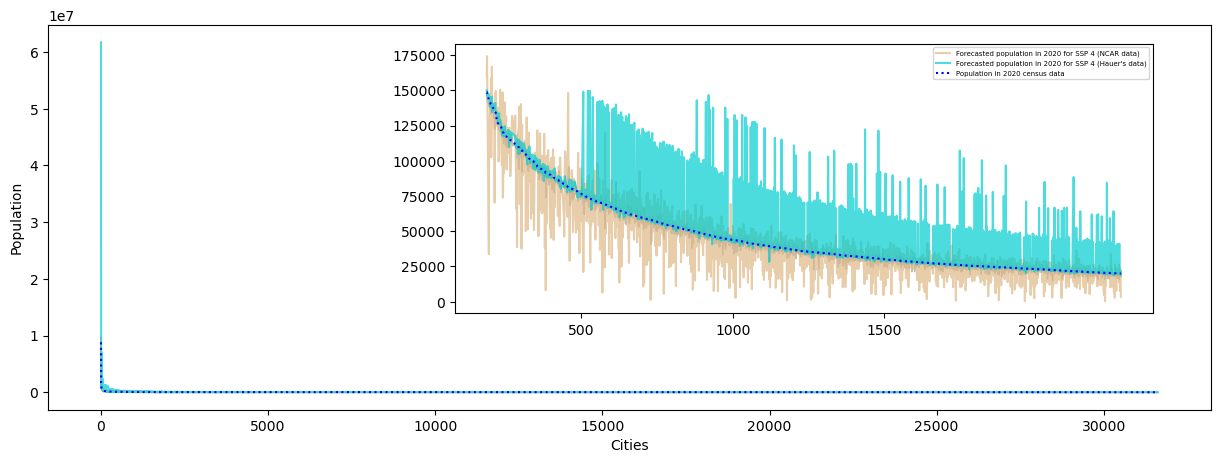

In [91]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df_main = df_complete.sort_values('CensusPop_20', ascending = False).reset_index()
df_inset= df_main[(df_main['forecast_ssp42020'] < 150000) & (df_main['CensusPop_20'] > 20000)]

fig, ax = plt.subplots(1, 1, figsize=[15, 5])
ax.plot(df_main.index, df_main['population_2020_ssp4'],"burlywood", alpha = 0.7, label = 'forecasted population 2040 for SSP 4');
ax.plot(df_main.index, df_main['forecast_ssp42020'], "darkturquoise", alpha = 0.7, label = 'forecasted population 2020 for SSP 4');
ax.plot(df_main.index, (df_main['CensusPop_20']), "b", linestyle='dotted', linewidth=1.5, label = 'Population in 2020 census data')

ax1 = ax.inset_axes((0.35,0.25,.6,.7)) #inset_axes(ax, width="50%", height=2, loc=2, borderpad=5)

ax1.plot(df_inset.index, df_inset['population_2020_ssp4'],"burlywood", alpha = 0.7, label = 'Forecasted population in 2020 for SSP 4 (NCAR data)');
ax1.plot(df_inset.index, df_inset['forecast_ssp42020'], "darkturquoise", alpha = 0.7, label = "Forecasted population in 2020 for SSP 4 (Hauer's data)");
ax1.plot(df_inset.index, (df_inset['CensusPop_20']), "b",linestyle='dotted', linewidth=1.5, label = 'Population in 2020 census data')

ax1.fill_between(df_inset.index, df_inset['P_20_upper'], df_inset['P_20_lower'], color="grey", alpha=0.5);

display = (0,1,2,3,4)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend([handle for i,handle in enumerate(handles) if i in display],
           [label for i,label in enumerate(labels) if i in display], loc = 'upper right', fontsize = 5)


# Turn ticklabels of insets off
for axi in [ax, ax1]:
    axi.tick_params(labelleft=True, labelbottom=True)
ax.set_xlabel('Cities')
ax.set_ylabel('Population')
plt.show()

# fig.savefig(r'D:\Work\Box Sync\PhD_Work_Uttara\NC_submission_shared\Final_submission\Final_plots\Plot variation in estimation and projected values.png', dpi = 300,
           # bbox_inches='tight', transparent="True", pad_inches=0)

In [65]:
len(df_complete.filter(regex= 'forecast').columns), len(df_complete.filter(regex= 'population_').columns)

(85, 50)

In [66]:
# A few checks on the dataset ---
# 15 CITIES IN ALASKA ARE COMMON WITH NO FORECAST AVAILABLE
df_complete[(df_complete['population_2020_ssp4'] == 0) & (df_complete['forecast_ssp42020'] == 0)][['GEOID', 'NAME','forecast_ssp42020', 
                                                                                                   'population_2020_ssp4','CensusPop_20']]
# 155 CITIES HAVE NO FORECAST AVAILABLE FROM NCAR DATA, THEY HAVE A MEAN POPULATION OF 228 with maximum 3102
# THIS ARE CITIES FROM ALASKA - California - NEVADA - New Mexico - 	Oregon - South Dakota - Wyoming
df_complete[df_complete['population_2020_ssp4'] == 0][['GEOID', 'NAME','forecast_ssp42020', 'population_2020_ssp4','CensusPop_20']]
# 73 CITIES HAVE NO FORECAST AVAILABLE FROM HAUER DATA, THEY HAVE A MEAN POPULATION OF 533 with maximum 3985
# THIS ARE CITIES FROM ALASKA AND SOUTH DAKOTA
df_complete[df_complete['forecast_ssp42020'] == 0][['GEOID', 'NAME','forecast_ssp42020', 'population_2020_ssp4','CensusPop_20']]
df_complete[['forecast_ssp42020','population_2020_ssp4','CensusPop_20']].isna().sum()

forecast_ssp42020       0
population_2020_ssp4    0
CensusPop_20            0
dtype: int64


Some cities are underprojectd by both datasets while some are overprojected. \
Therefore, we weighted the datasets based on whether they are ----  \
underprojected, overprojected or lie in the middle.


In [67]:
df_complete['%diff_Hauer'] = (df_complete['CensusPop_20'] - df_complete['forecast_ssp42020']) / df_complete['CensusPop_20']
df_complete['%diff_NCAR'] = (df_complete['CensusPop_20'] - df_complete['population_2020_ssp4']) / df_complete['CensusPop_20']
df_complete_middle = df_complete[((df_complete['%diff_Hauer'] >= 0) & (df_complete['%diff_NCAR'] <= 0)) | \
                                 ((df_complete['%diff_Hauer'] <= 0) & (df_complete['%diff_NCAR'] >= 0))]
df_complete_middle.shape

(15795, 257)

============== For cities in the Middle ==============

1051.3171172051063


<Axes: >

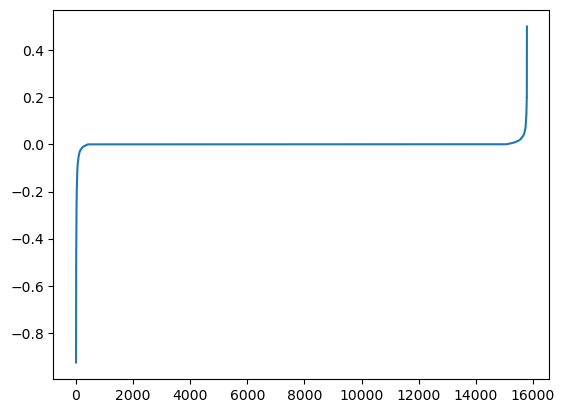

In [68]:
df11 = df_complete_middle.copy()

df11['diff_Hauer'] = np.abs(df11['CensusPop_20'] - df11['forecast_ssp42020']) 
df11['diff_NCAR'] = np.abs(df11['CensusPop_20'] - df11['population_2020_ssp4']) 


df11['w1']  = 1 / df11['diff_Hauer'] #(df_complete['diff_Hauer'] - min_val) / (max_val - min_val)
df11['w2']  = 1 / df11['diff_NCAR'] #(df_complete['diff_NCAR'] - min_val) / (max_val - min_val)

# df_complete['w1'] = (df_complete['diff_Hauer'] - df_complete['diff_Hauer'].min()) / (df_complete['diff_Hauer'].max() - df_complete['diff_Hauer'].min())
# df_complete['w2'] = (df_complete['diff_NCAR'] - df_complete['diff_NCAR'].min()) / (df_complete['diff_NCAR'].max() - df_complete['diff_NCAR'].min())

df11['w1'].replace(np.inf, 1, inplace =  True,)
df11['w2'].replace(np.inf, 1, inplace =  True)

df11['w3'] = df11['w1']/ (df11['w1'] + df11['w2'])
df11['w4'] = df11['w2']/ (df11['w1'] + df11['w2'])

df11['new'] = df11['w3']* df11['forecast_ssp42020'] + df11['w4'] * df11['population_2020_ssp4']
print(np.sum(np.abs(df11['new'] - df11['CensusPop_20'])) ) #/ np.sum(df_complete['CensusPop_20']))
df11['%diff'] = ((df11['CensusPop_20']-df11['new'])) /df11['CensusPop_20']
df11['diff'] = ((df11['CensusPop_20']-df11['new']))

df11['%diff'].sort_values().reset_index(drop=True).plot()

In [69]:
# df11[['GEOID', 'NAME','CensusPop_20', 'forecast_ssp42020', 'population_2020_ssp4',
#       'new', 'diff_Hauer', 'diff_NCAR',  'w1', 'w2', 'w3', 'w4', '%diff', 'diff']].sort_values(by = 'diff')
df11[['new', 'CensusPop_20', 'forecast_ssp42020', 'population_2020_ssp4',]].sum()

new                     1.171347e+08
CensusPop_20            1.171350e+08
forecast_ssp42020       2.060062e+08
population_2020_ssp4    9.967472e+07
dtype: float64

In [70]:
df_complete_under = df_complete[((df_complete['%diff_Hauer'] > 0) & (df_complete['%diff_NCAR'] > 0))]
df_complete_over = df_complete[((df_complete['%diff_Hauer'] < 0) & (df_complete['%diff_NCAR'] < 0))]

In [71]:
df_complete_under.shape, df_complete_over.shape

((10249, 257), (5524, 257))

============== For underprojected cities ==============

29981.500000000204


<Axes: >

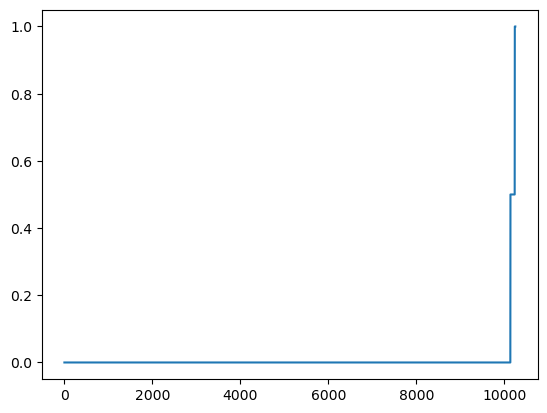

In [72]:
df22 = df_complete_under.copy()

df22['diff_Hauer'] = 1 /(df22['forecast_ssp42020'] / df22['CensusPop_20'])   # here diff refers to ratio
df22['diff_NCAR'] = 1 /(df22['population_2020_ssp4'] / df22['CensusPop_20'])

df22['w1'] = df22['diff_Hauer'] 
df22['w2'] = df22['diff_NCAR']

df22['w1'].replace(np.inf, 1, inplace =  True,)
df22['w2'].replace(np.inf, 1, inplace =  True)

df22['w3'] = df22['w1']/ 2
df22['w4'] = df22['w2']/ 2

df22['new'] = df22['w3']* df22['forecast_ssp42020'] + df22['w4'] * df22['population_2020_ssp4']
print(np.sum(np.abs(df22['new'] - df22['CensusPop_20'])) ) #/ np.sum(df_complete['CensusPop_20']))
df22['%diff'] = ((df22['CensusPop_20']-df22['new'])) /df22['CensusPop_20']
df22['diff'] = ((df22['CensusPop_20']-df22['new']))

df22['%diff'].sort_values().reset_index(drop=True).plot()

============== For overprojected cities ==============

5.174847217404022e-10


<Axes: >

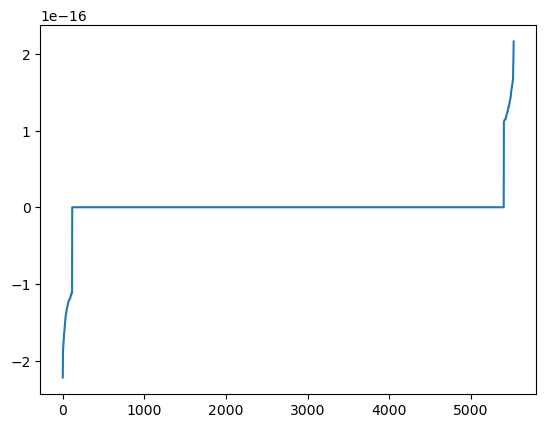

In [73]:
df33 = df_complete_over.copy()

df33['diff_Hauer'] = 1 /(df33['forecast_ssp42020'] / df33['CensusPop_20'])
df33['diff_NCAR'] = 1 /(df33['population_2020_ssp4'] / df33['CensusPop_20'])

df33['w1'] = df33['diff_Hauer'] 
df33['w2'] = df33['diff_NCAR']

df33['w1'].replace(np.inf, 1, inplace =  True,)
df33['w2'].replace(np.inf, 1, inplace =  True)

df33['w3'] = df33['w1']/ 2
df33['w4'] = df33['w2']/ 2

df33['new'] = df33['w3']* df33['forecast_ssp42020'] + df33['w4'] * df33['population_2020_ssp4']
print(np.sum(np.abs(df33['new'] - df33['CensusPop_20'])) ) #/ np.sum(df_complete['CensusPop_20']))
df33['%diff'] = ((df33['CensusPop_20']-df33['new'])) /df33['CensusPop_20']
df33['diff'] = ((df33['CensusPop_20']-df33['new']))

df33['%diff'].sort_values().reset_index(drop=True).plot()

In [74]:
df11.shape, df22.shape, df33.shape

((15795, 265), (10249, 265), (5524, 265))

In [75]:
# merging all together
df_with_weights = pd.concat([df11, df22, df33], axis =0).reset_index(drop=True)

In [76]:
# df_with_weights[['NAME', 'CensusPop_20', 'forecast_ssp42020', 'population_2020_ssp4', 'new', 'w3', 'w4']]

(31616, 257)


<Axes: >

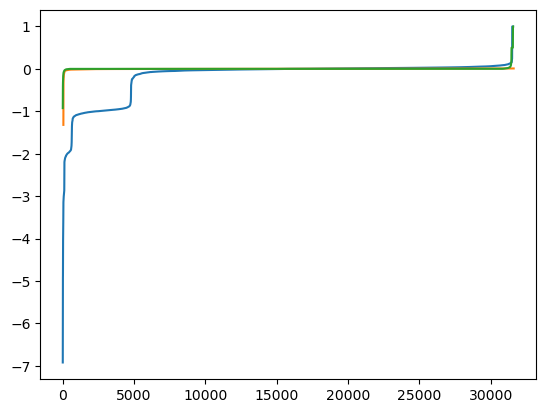

In [77]:
print(df_complete.shape)

((df_complete['CensusPop_20'] - df_complete['forecast_ssp42020'])/ df_complete['CensusPop_20']).sort_values().reset_index(drop=True).plot() 
((df_complete['CensusPop_20'] - df_complete['population_2020_ssp4'])/ df_complete['CensusPop_20']/100).sort_values().reset_index(drop=True).plot() 

df_with_weights['%diff'].sort_values().reset_index(drop=True).plot() # [df_complete['%diff'] !=1]

# Preparing data to forecast trend
1. Multiply by the weights
2. Sum weighted data
3. Concatenate all years to create df_for_forecast

In [78]:
df_w3 = df_with_weights.filter(regex= 'forecast').multiply(df_with_weights['w3'], axis="index")
df_w3.columns = df_w3.columns.str.split('_').str[1]
df_w4 = df_with_weights.filter(regex= 'population').multiply(df_with_weights['w4'], axis="index")
df_w4.columns = df_w4.columns.str.split('population_').str[1]

In [79]:
df_w4.columns = ['ssp12010', 'ssp12020', 'ssp12030', 'ssp12040', 'ssp12050',
                 'ssp12060', 'ssp12070', 'ssp12080', 'ssp12090', 'ssp12100',
                 'ssp22010', 'ssp22020', 'ssp22030', 'ssp22040', 'ssp22050',
                 'ssp22060', 'ssp22070', 'ssp22080', 'ssp22090', 'ssp22100',
                 'ssp32010', 'ssp32020', 'ssp32030', 'ssp32040', 'ssp32050',
                 'ssp32060', 'ssp32070', 'ssp32080', 'ssp32090', 'ssp32100',
                 'ssp42010', 'ssp42020', 'ssp42030', 'ssp42040', 'ssp42050',
                 'ssp42060', 'ssp42070', 'ssp42080', 'ssp42090', 'ssp42100',
                 'ssp52010', 'ssp52020', 'ssp52030', 'ssp52040', 'ssp52050',
                 'ssp52060', 'ssp52070', 'ssp52080', 'ssp52090', 'ssp52100']

In [80]:
df_2020 = df_w3.filter(regex='2020') + df_w4.filter(regex='2020')
df_2030 = df_w3.filter(regex='2030') + df_w4.filter(regex='2030')
df_2040 = df_w3.filter(regex='2040') + df_w4.filter(regex='2040')
df_2050 = df_w3.filter(regex='2050') + df_w4.filter(regex='2050')
df_2060 = df_w3.filter(regex='2060') + df_w4.filter(regex='2060')
df_2070 = df_w3.filter(regex='2070') + df_w4.filter(regex='2070')
df_2080 = df_w3.filter(regex='2080') + df_w4.filter(regex='2080')
df_2090 = df_w3.filter(regex='2090') + df_w4.filter(regex='2090')
df_2100 = df_w3.filter(regex='2100') + df_w4.filter(regex='2100')

In [81]:
# merging weighted summed datasets

In [82]:
df_for_forecast = pd.concat([df_2020, df_2030, df_2040, df_2050, df_2060, 
                             df_2070, df_2080, df_2090, df_2100, df_with_weights[['GEOID']]], axis =1)

In [83]:
# df_for_forecast.to_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\df_cleaned_for_forecast.csv')

In [84]:
forecasted_df = df_for_forecast.copy()
# Check length of columns for each scenario
len(forecasted_df.filter(regex='ssp2').columns)

9

In [85]:
forecasted_df['find_trend_ssp1'] = forecasted_df[forecasted_df.filter(regex='ssp1').columns].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp2'] = forecasted_df[forecasted_df.filter(regex='ssp2').columns].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp3'] = forecasted_df[forecasted_df.filter(regex='ssp3').columns].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp4'] = forecasted_df[forecasted_df.filter(regex='ssp4').columns].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp5'] = forecasted_df[forecasted_df.filter(regex='ssp5').columns].astype(str).fillna('').apply(', '.join, axis=1)

# Mann Kendall test to find trend from forecasted data

In [86]:
import pymannkendall as mk
import numpy as np
test_res = []

column_name = ['find_trend_ssp1','find_trend_ssp2', 'find_trend_ssp3', 'find_trend_ssp4', 'find_trend_ssp5']

for i in range(0,len(column_name)):
    for j in range(0,len(forecasted_df[column_name])):
        test_res.append(mk.original_test(np.asarray([float(k) for k in forecasted_df.iloc[j][column_name[i]].split(',')]), alpha=0.05))  

for i in range(0,len(column_name)):
    new_col_name = 'result' + column_name[i][10:]
    forecasted_df[new_col_name] =  test_res[(i*len(forecasted_df)):(i+1)*len(forecasted_df)]

In [87]:
forecasted_df['future trend from SSP 1'] = ''
forecasted_df['future trend from SSP 2'] = ''
forecasted_df['future trend from SSP 3'] = ''
forecasted_df['future trend from SSP 4'] = ''
forecasted_df['future trend from SSP 5'] = ''

In [88]:
pd.options.mode.chained_assignment = None 
for i in range(len(forecasted_df)):
    forecasted_df['future trend from SSP 1'][i] = forecasted_df['result_ssp1'][i][0]
    forecasted_df['future trend from SSP 2'][i] = forecasted_df['result_ssp2'][i][0]
    forecasted_df['future trend from SSP 3'][i] = forecasted_df['result_ssp3'][i][0]
    forecasted_df['future trend from SSP 4'][i] = forecasted_df['result_ssp4'][i][0]
    forecasted_df['future trend from SSP 5'][i] = forecasted_df['result_ssp5'][i][0]

In [89]:
forecasted_df[['future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 'future trend from SSP 4',
    'future trend from SSP 5']].apply(pd.Series.value_counts)

,future trend from SSP 1,future trend from SSP 2,future trend from SSP 3,future trend from SSP 4,future trend from SSP 5
decreasing,14356,15332,26732,20067,2997
increasing,13317,13051,1041,5729,27102
no trend,3895,3185,3795,5772,1469


# Joining forecasted dataframe with spatial data

In [124]:
# =========== DEFINING df for use rest of the section
df = places_merged.merge(forecasted_df, left_on='GEOID', right_on='GEOID', how = 'left')

In [125]:
df[['GEOID', 'NAME', 'NAMELSAD', 'LSAD','ALAND', 'CensusPop_20', 'label', 'State',
       'ssp12020', 'ssp22020', 'ssp32020', 'ssp42020', 'ssp52020', 'ssp12030',
       'ssp22030', 'ssp32030', 'ssp42030', 'ssp52030', 'ssp12040', 'ssp22040',
       'ssp32040', 'ssp42040', 'ssp52040', 'ssp12050', 'ssp22050', 'ssp32050',
       'ssp42050', 'ssp52050', 'ssp12060', 'ssp22060', 'ssp32060', 'ssp42060',
       'ssp52060', 'ssp12070', 'ssp22070', 'ssp32070', 'ssp42070', 'ssp52070',
       'ssp12080', 'ssp22080', 'ssp32080', 'ssp42080', 'ssp52080', 'ssp12090',
       'ssp22090', 'ssp32090', 'ssp42090', 'ssp52090', 'ssp12100', 'ssp22100',
       'ssp32100', 'ssp42100', 'ssp52100', 'future trend from SSP 1',
       'future trend from SSP 2', 'future trend from SSP 3',
       'future trend from SSP 4', 'future trend from SSP 5', 
    ]].to_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\forecasted_trend.csv')

In [127]:
df[['future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 'future trend from SSP 4',
    'future trend from SSP 5']].apply(pd.Series.value_counts)/ df['future trend from SSP 2'].value_counts().sum()

,future trend from SSP 1,future trend from SSP 2,future trend from SSP 3,future trend from SSP 4,future trend from SSP 5
decreasing,0.454764,0.485682,0.846807,0.635675,0.094938
increasing,0.421851,0.413425,0.032976,0.181481,0.858528
no trend,0.123384,0.100893,0.120217,0.182843,0.046534


In [74]:
df[['future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 'future trend from SSP 4',
    'future trend from SSP 5']].apply(pd.Series.value_counts)

,future trend from SSP 1,future trend from SSP 2,future trend from SSP 3,future trend from SSP 4,future trend from SSP 5
decreasing,14356,15332,26732,20067,2997
increasing,13317,13051,1041,5729,27102
no trend,3895,3185,3795,5772,1469


In [78]:
df['future trend from SSP 2'].value_counts().sum(), df.shape
df[['future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 'future trend from SSP 4', 'future trend from SSP 5']].count()

future trend from SSP 1    31568
future trend from SSP 2    31568
future trend from SSP 3    31568
future trend from SSP 4    31568
future trend from SSP 5    31568
dtype: int64

In [132]:
# Cartographic boundary for plotting
US_counties_cb = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\cb_2020_us_county_5m.zip') # tl_2020_us_county
US_states_cb = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\cb_2020_us_state_5m.zip')  # tl_2020_us_state

# source: https://gis.stackexchange.com/questions/141580/which-projection-is-best-for-mapping-the-contiguous-united-states
US_states_cb = US_states_cb.to_crs('EPSG:9311')
US_counties_cb = US_counties_cb.to_crs('EPSG:9311')

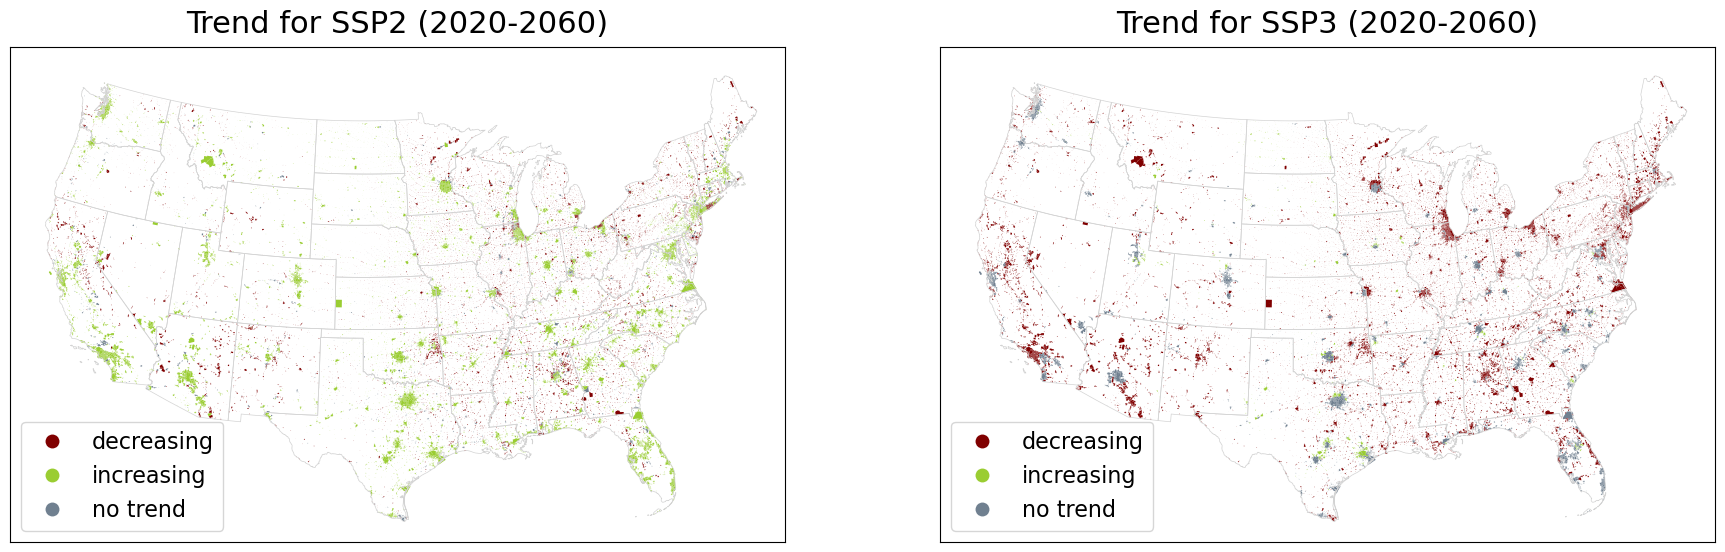

In [133]:
df = df.to_crs('EPSG:9311')
#US_states = US_states.to_crs('EPSG:9311')
columns = ['future trend from SSP 2', 'future trend from SSP 3'] 
colors = ['maroon','yellowgreen','slategray']
title_dict = {'trend':'Trend from ACS data 2010-2020', 'future trend from SSP 1':'Trend for SSP1 (2020-2060)', 
              'future trend from SSP 2':'Trend for SSP2 (2020-2060)', 'future trend from SSP 3': 'Trend for SSP3 (2020-2060)',
              'future trend from SSP 4': 'Trend for SSP4 (2020-2060)', 'future trend from SSP 5':'Trend for SSP5 (2020-2060)'}

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22,12))

for ax,col in zip(ax.flatten(), columns):
    xlim = ([-2257388.37, 2695859.75]) 
    ylim = ([-2246944.04, 918095.9])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    cmap_colors = matplotlib.colors.ListedColormap(colors)
    base = US_states_cb.boundary.plot(ax =ax, edgecolor = 'lightgray', linewidth = 0.5)
    df.plot(ax =ax, column = col, cmap=cmap_colors, legend = True, legend_kwds={'loc': 'lower left','fontsize': 16, })
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax.set_title(title_dict.get(col), fontsize=22, pad=10)

fig.savefig(r'D:\Work\Box Sync\NC Figures\All Trends from forecast.png', dpi = 900)

# Check density variation

In [134]:
df['density_km2'] = df['CensusPop_20'] *1000*1000 / df['ALAND']

In [135]:
df[df['density_km2'] != 0].groupby(['label'])['density_km2'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
1 severely depopulating,159.0,127.5,296.3,0.0,8.3,32.4,97.6,2313.6
2 moderately depopulating,4565.0,255.5,363.9,0.0,77.1,169.5,316.5,10856.8
3 slowly depopulating,5708.0,475.6,578.2,0.0,165.8,323.5,566.1,8283.4
4 fluctuating,4124.0,512.1,630.0,0.0,152.6,333.8,601.3,6910.9
5 slowly increasing,5500.0,780.9,1016.8,0.0,243.0,483.9,963.0,24038.5
6 moderately increasing,3611.0,668.3,866.1,0.6,199.3,436.6,838.2,18659.2
7 highly increasing,570.0,457.9,591.5,0.0,112.9,320.3,616.5,8704.4


In [136]:
df[df['density_km2'] != 0].groupby('label')['density_km2'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
1 severely depopulating,159.0,127.5,296.3,0.0,8.3,32.4,97.6,2313.6
2 moderately depopulating,4565.0,255.5,363.9,0.0,77.1,169.5,316.5,10856.8
3 slowly depopulating,5708.0,475.6,578.2,0.0,165.8,323.5,566.1,8283.4
4 fluctuating,4124.0,512.1,630.0,0.0,152.6,333.8,601.3,6910.9
5 slowly increasing,5500.0,780.9,1016.8,0.0,243.0,483.9,963.0,24038.5
6 moderately increasing,3611.0,668.3,866.1,0.6,199.3,436.6,838.2,18659.2
7 highly increasing,570.0,457.9,591.5,0.0,112.9,320.3,616.5,8704.4


In [137]:
df[df['density_km2'] != 0].groupby('future trend from SSP 1')['density_km2'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
future trend from SSP 1,,,,,,,,
decreasing,14356.0,277.95,315.56,0.00,75.89,190.32,373.06,5142.17
increasing,13317.0,727.47,1015.16,0.02,161.49,427.28,929.12,35050.55
no trend,3895.0,395.62,479.45,0.00,92.87,252.76,514.02,5253.10


In [138]:
df[df['density_km2'] != 0].groupby('future trend from SSP 2')['density_km2'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
future trend from SSP 2,,,,,,,,
decreasing,15332.0,283.46,324.65,0.00,76.78,192.32,379.26,5142.17
increasing,13051.0,732.55,1021.65,0.02,163.75,430.34,934.49,35050.55
no trend,3185.0,412.07,501.39,0.00,93.43,261.26,528.70,5253.10


In [139]:
df[df['density_km2'] != 0].groupby('future trend from SSP 4')['density_km2'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
future trend from SSP 4,,,,,,,,
decreasing,20067.0,314.79,382.50,0.00,81.02,206.18,410.52,8704.41
increasing,5729.0,755.08,1140.75,0.02,167.84,459.11,962.89,35050.55
no trend,5772.0,792.83,979.87,0.00,179.84,462.00,1048.11,12333.73


# Land area in depopulated cities 

In [140]:
print('Area of deopulating cities as percent of total populated area--- for SSP 1:')
print(df.groupby(['future trend from SSP 1'])['ALAND'].sum()/ df.groupby(['future trend from SSP 1'])['ALAND'].sum().sum())

print('Area of deopulating cities as percent of total populated area--- for SSP 2:')
print(df.groupby(['future trend from SSP 2'])['ALAND'].sum()/ df.groupby(['future trend from SSP 2'])['ALAND'].sum().sum())

print('Area of deopulating cities as percent of total populated area--- for SSP 4:')
print(df.groupby(['future trend from SSP 4'])['ALAND'].sum()/ df.groupby(['future trend from SSP 4'])['ALAND'].sum().sum())
print('\n')
print('This excludes area of any water bodies inside the cities.')

Area of deopulating cities as percent of total populated area--- for SSP 1:
future trend from SSP 1
decreasing    0.222568
increasing    0.642105
no trend      0.135327
Name: ALAND, dtype: float64
Area of deopulating cities as percent of total populated area--- for SSP 2:
future trend from SSP 2
decreasing    0.246666
increasing    0.646568
no trend      0.106766
Name: ALAND, dtype: float64
Area of deopulating cities as percent of total populated area--- for SSP 4:
future trend from SSP 4
decreasing    0.412311
increasing    0.331313
no trend      0.256376
Name: ALAND, dtype: float64


This excludes area of any water bodies inside the cities.


In [141]:
# df.groupby(['future trend from SSP 4'])['CensusPop_20'].sum()/ df.groupby(['future trend from SSP 4'])['CensusPop_20'].sum().sum()

In [142]:
df.groupby(['label'])['CensusPop_20'].sum()/ df.groupby(['future trend from SSP 4'])['CensusPop_20'].sum().sum()

label
1 severely depopulating      0.000175
2 moderately depopulating    0.019848
3 slowly depopulating        0.099539
4 fluctuating                0.087691
5 slowly increasing          0.410294
6 moderately increasing      0.303836
7 highly increasing          0.023682
Name: CensusPop_20, dtype: float64

In [143]:
df.groupby(['future trend from SSP 1'])['ALAND'].sum()/ df.groupby(['future trend from SSP 1'])['ALAND'].sum().sum()

future trend from SSP 1
decreasing    0.222568
increasing    0.642105
no trend      0.135327
Name: ALAND, dtype: float64

In [144]:
df.groupby(['future trend from SSP 4'])['ALAND'].sum()/ df.groupby(['future trend from SSP 4'])['ALAND'].sum().sum()

future trend from SSP 4
decreasing    0.412311
increasing    0.331313
no trend      0.256376
Name: ALAND, dtype: float64

C:\Users\uttar\AppData\Local\Temp\ipykernel_3892\2308685401.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Expected Trend", y="No of cities",


<Axes: xlabel='Expected Trend', ylabel='No of cities'>

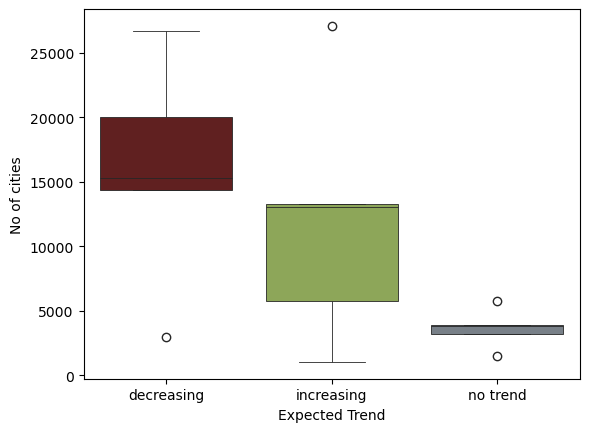

In [145]:
trend_sce_df = pd.DataFrame()
trend_sce_df['SSP 1'] = df['future trend from SSP 1'].value_counts()
trend_sce_df['SSP 2'] = df['future trend from SSP 2'].value_counts()
trend_sce_df['SSP 3'] = df['future trend from SSP 3'].value_counts()
trend_sce_df['SSP 4'] = df['future trend from SSP 4'].value_counts()
trend_sce_df['SSP 5'] = df['future trend from SSP 5'].value_counts()

import seaborn as sns
sns.boxplot(x="Expected Trend", y="No of cities", 
            data=pd.melt(trend_sce_df.T, var_name='Expected Trend', value_name='No of cities', col_level=None, ignore_index=False),
            palette = ['maroon','yellowgreen','slategray'],
            saturation=0.5,
            linewidth=0.6,
           )

In [146]:
df[df['density_km2'] != 0]['density_km2'].min()

0.003232994838342693

In [147]:
df['GEOID'] = df['GEOID'].astype(str).str.rjust(7,'0')

In [150]:
df.groupby(['label', 'future trend from SSP 1']).size()*100/ df.groupby(['label']).size()

label                      future trend from SSP 1
1 severely depopulating    decreasing                 49.685535
                           increasing                 29.559748
                           no trend                   20.754717
2 moderately depopulating  decreasing                 68.849945
                           increasing                 20.087623
                           no trend                   11.062432
3 slowly depopulating      decreasing                 60.669236
                           increasing                 26.909601
                           no trend                   12.421163
4 fluctuating              decreasing                 47.065955
                           increasing                 39.209505
                           no trend                   13.724539
5 slowly increasing        decreasing                 27.254545
                           increasing                 59.472727
                           no trend                  

In [151]:
df.groupby(['label', 'future trend from SSP 2']).size()*100/ df.groupby(['label']).size()

label                      future trend from SSP 2
1 severely depopulating    decreasing                 52.830189
                           increasing                 29.559748
                           no trend                   17.610063
2 moderately depopulating  decreasing                 71.434830
                           increasing                 19.912377
                           no trend                    8.652793
3 slowly depopulating      decreasing                 64.138052
                           increasing                 26.576734
                           no trend                    9.285214
4 fluctuating              decreasing                 50.751697
                           increasing                 38.288070
                           no trend                   10.960233
5 slowly increasing        decreasing                 30.490909
                           increasing                 58.327273
                           no trend                  

In [152]:
df.groupby(['label', 'future trend from SSP 4']).size()*100/ df.groupby(['label']).size()

label                      future trend from SSP 4
1 severely depopulating    decreasing                 72.327044
                           increasing                 11.320755
                           no trend                   16.352201
2 moderately depopulating  decreasing                 84.205915
                           increasing                  7.623220
                           no trend                    8.170865
3 slowly depopulating      decreasing                 78.521374
                           increasing                  8.952348
                           no trend                   12.526279
4 fluctuating              decreasing                 67.774006
                           increasing                 14.258002
                           no trend                   17.967992
5 slowly increasing        decreasing                 48.000000
                           increasing                 23.436364
                           no trend                  

In [153]:
# Save the forecasted dataframe 
from datetime import date
today = date.today()

file_name = 'forecasted_trend_' + str(date.today())
# df.to_csv(r'D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\forecast trend output\\' + file_name + '.csv')

In [154]:
county_Projection[['ssp32020', 'ssp32040', 'ssp32050', 'ssp32060']].sum(), forecasted_df[['ssp32020', 'ssp32040', 'ssp32050', 'ssp32060', ]].sum()
# 245375572.0/3.287417e+08, 256977104.0/3.388857e+08, 255146017.0/3.342000e+08, 250260502.0/3.260763e+08

(ssp32020    3.287505e+08
 ssp32040    3.388928e+08
 ssp32050    3.342065e+08
 ssp32060    3.260822e+08
 dtype: float64,
 ssp32020    2.460211e+08
 ssp32040    2.571268e+08
 ssp32050    2.552045e+08
 ssp32060    2.503629e+08
 dtype: float64)

In [155]:
df['future trend from SSP 1'].value_counts().sum(), df['future trend from SSP 2'].value_counts().sum(), df['future trend from SSP 4'].value_counts().sum()

(31568, 31568, 31568)

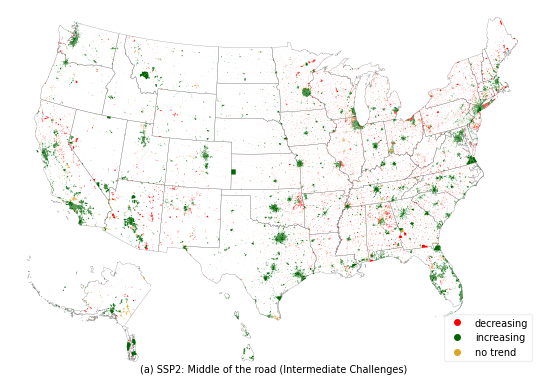

In [156]:
# import the United States shape file
# set state code as index, exclude states that we will never display
gdf = df.set_index('STATEFP') #.drop(index=['02', 'VI', 'MP', 'GU', 'AS'])
colors = ['red','darkgreen','goldenrod']

# column_name = ["future trend from SSP 2", "future trend from SSP 4"]
x_labels = {"future trend from SSP 1": "(a) SSP1: Taking the Green Road (Low Challenges)",
            "future trend from SSP 2": "(a) SSP2: Middle of the road (Intermediate Challenges)", 
            "future trend from SSP 4": '(b) SSP4: A Road Divided (Adaptation challenges dominate)'}
col= "future trend from SSP 2"

mm = 1/(10* 2.54)  # milimeters in inches

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(180*mm, 100*mm))


continental_ax = ax
alaska_ax = ax.inset_axes([.01, .01, .28, .30])
hawaii_ax = ax.inset_axes([.30, .01, .25, .2])
               
# Set bounds to fit desired areas in each plot
continental_ax.set_xlim(-2257388.37, 2695859.75)
continental_ax.set_ylim(-2546944.04, 808080.9)
continental_ax.set_title((x_labels[col]).strip('\"'), fontsize = 7, 
                     loc='center',  y=-0.04)

alaska_ax.set_xlim(-4383115.86156959, -1515327.22537998)
alaska_ax.set_ylim(1458524.37417163, 3919523.37426209)

hawaii_ax.set_xlim(-5812090.887043, -5452538.83170424)   # complete bounds 
hawaii_ax.set_ylim(-1064618.58269969, -431238.37803499)
               
               
US_states_cb.plot(ax=continental_ax, facecolor = 'none', edgecolor='gray', linewidth=0.2)
gdf.plot(column=col, 
             ax=continental_ax,
             cmap=matplotlib.colors.ListedColormap(colors), 
             legend = True,
             legend_kwds={'loc': 'lower right', 'fontsize': 7,
                         'markerscale': 0.5})

leg = continental_ax.get_legend()
# leg.set_bbox_to_anchor((0.07, 0.02, 0.7, 0.2))
leg.get_frame().set_alpha(0.3)

US_states_cb.plot(facecolor = 'none', edgecolor='gray', linewidth=0.2, ax=alaska_ax)
gdf.plot(column=col, cmap=matplotlib.colors.ListedColormap(colors), ax=alaska_ax) 

US_states_cb.plot(facecolor = 'none', edgecolor='gray', linewidth=0.2, ax=hawaii_ax)
gdf.plot(column=col, cmap=matplotlib.colors.ListedColormap(colors), ax=hawaii_ax,
                    missing_kwds = dict(color='black'))

    # remove ticks
for ax in [continental_ax, alaska_ax, hawaii_ax]:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')
    plt.tight_layout()
    plt.axis('off') 
        
fig.patch.set_visible(False)

fig.savefig(r'D:\Work\Box Sync\NC Figures\all states trend SSP 2' + '.png', dpi = 300,
           bbox_inches='tight')
fig.savefig(r'D:\Work\Box Sync\NC Figures\all states trend SSP 2' + '.pdf', dpi = 300,
           bbox_inches='tight')

In [157]:
# df[df['STATEFP'] == '15'].plot(column='future trend from SSP 2', cmap=cmap, legend = True)
# df['future trend from SSP 2'].unique()

In [158]:
df[(df['STATEFP'] != '02') & (df['STATEFP'] != '15')]['STATEFP'].unique()

array(['01', '04', '05', '06', '08', '09', '10', '11', '12', '13', '16',
       '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27',
       '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50',
       '51', '53', '54', '55', '56'], dtype=object)

# Plotting the future trends

['decreasing' 'no trend' 'increasing' nan]
['increasing' 'no trend']
['decreasing' 'increasing' 'no trend' nan]
['increasing' 'no trend' 'decreasing']


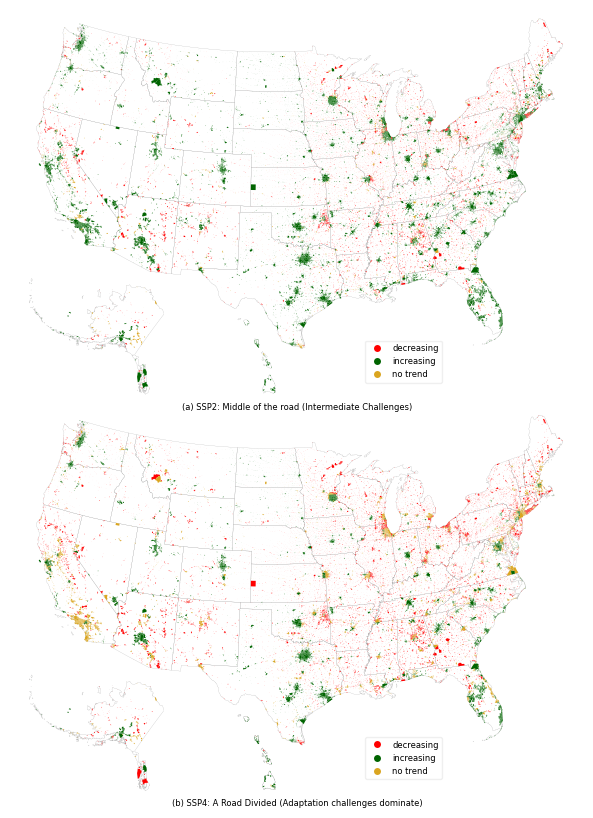

In [159]:
# import the United States shape file
# set state code as index, exclude states that we will never display
gdf = df.set_index('STATEFP') #.drop(index=['02', 'VI', 'MP', 'GU', 'AS'])
# colors = ['red','darkgreen','goldenrod']
colors = {
    'decreasing': 'red',
    'increasing': 'darkgreen', 
    'no trend': 'goldenrod'
}
cmap = matplotlib.colors.ListedColormap([t[1] for t in sorted(colors.items())]) #Sorting by keys before converting to list


column_name = ["future trend from SSP 2", "future trend from SSP 4"]
x_labels = {"future trend from SSP 2": "(a) SSP2: Middle of the road (Intermediate Challenges)", 
            "future trend from SSP 4": '(b) SSP4: A Road Divided (Adaptation challenges dominate)'}

mm = 1/(25.4)  # milimeters in inches
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8.27,8.27))

for ax, col in zip(axes.flatten(), column_name):
    continental_ax = ax
    alaska_ax = ax.inset_axes([.01, .01, .28, .30])
    hawaii_ax = ax.inset_axes([.30, .01, .25, .2])
               
    # Set bounds to fit desired areas in each plot
    continental_ax.set_xlim(-2257388.37, 2695859.75)
    continental_ax.set_ylim(-2546944.04, 808080.9)
    continental_ax.set_title((x_labels[col]).strip('\"'), fontsize = 6, 
                     loc='center',  y=-0.05)

    alaska_ax.set_xlim(-4383115.86156959, -1515327.22537998)
    alaska_ax.set_ylim(1458524.37417163, 3919523.37426209)

    hawaii_ax.set_xlim(-5812090.887043, -5452538.83170424)   # complete bounds 
    hawaii_ax.set_ylim(-1064618.58269969, -431238.37803499)
               
               
    US_states_cb.plot(ax=continental_ax, facecolor = 'none', edgecolor='gray', linewidth=0.1)
    df[(df['STATEFP'] != '02') & (df['STATEFP'] != '15')].plot(column=col, 
             ax=continental_ax,
             cmap=cmap, #matplotlib.colors.ListedColormap(colors), 
             legend = True,
             legend_kwds={'loc': 'lower right', 'fontsize': 6,
                                              'markerscale': 0.5})
    leg = continental_ax.get_legend()
    leg.set_bbox_to_anchor((0.06, 0.03, 0.7, 0.2))
    leg.get_frame().set_alpha(0.3)

    print(df[df['STATEFP'] == '02'][col].unique())
    US_states_cb[US_states_cb['STATEFP'] == '02'].plot(facecolor = 'none', edgecolor='gray', linewidth=0.1, ax=alaska_ax)
    df[df['STATEFP'] == '02'].plot(column=col, cmap=cmap, ax=alaska_ax) 

    US_states_cb[US_states_cb['STATEFP'] == '15'].plot(facecolor = 'none', edgecolor='gray', linewidth=0.1, ax=hawaii_ax)
    print(df[df['STATEFP'] == '15'][col].unique())
    if col == "future trend from SSP 2":
        df[df['STATEFP'] == '15'].plot(column=col, cmap=matplotlib.colors.ListedColormap(['darkgreen','goldenrod']), 
                                   ax=hawaii_ax,  missing_kwds = dict(color='black'))
    else:
        US_states_cb.plot(facecolor = 'none', edgecolor='gray', linewidth=0.1, ax=hawaii_ax)
        df[df['STATEFP'] == '15'].plot(column=col, cmap=cmap, 
                                   ax=hawaii_ax,  missing_kwds = dict(color='black'))
    

    # remove ticks
    for ax in [continental_ax, alaska_ax, hawaii_ax]:
        ax.set_yticks([])
        ax.set_xticks([])
        ax.axis('off')
        plt.tight_layout()
        plt.axis('off') 
        
plt.subplots_adjust(wspace=0, hspace=0.02)       
fig.patch.set_visible(False)

fig.savefig(r'D:\Work\Box Sync\NC Figures\all states trend SSP 2 and 4' + '.png', dpi = 300,
           bbox_inches='tight')
# fig.savefig(r'D:\Work\Box Sync\NC Figures\all states trend SSP 2 and 4' + '.pdf', dpi = 300,
#            bbox_inches='tight')

['decreasing' 'no trend' 'increasing' nan]
['decreasing' 'increasing' 'no trend' nan]


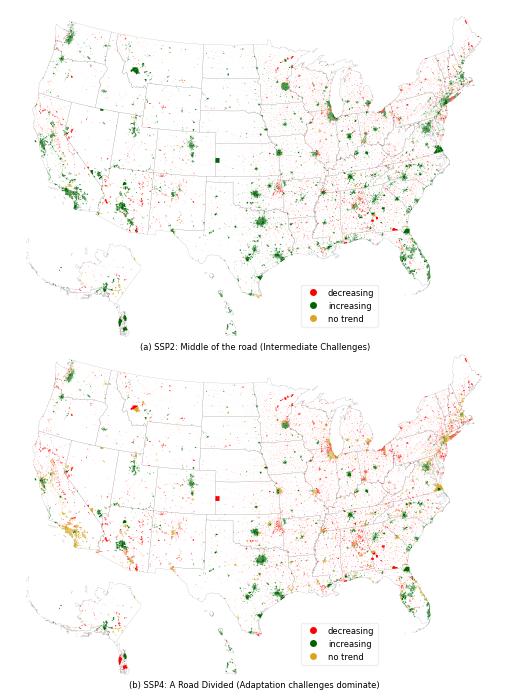

In [160]:
# import the United States shape file
# set state code as index, exclude states that we will never display
gdf = df.set_index('STATEFP') #.drop(index=['02', 'VI', 'MP', 'GU', 'AS'])
# colors = ['red','darkgreen','goldenrod']
colors = {
    'decreasing': 'red',
    'increasing': 'darkgreen', 
    'no trend': 'goldenrod'
}
cmap = matplotlib.colors.ListedColormap([t[1] for t in sorted(colors.items())]) #Sorting by keys before converting to list


column_name = ["future trend from SSP 2", "future trend from SSP 4"]
x_labels = {"future trend from SSP 2": "(a) SSP2: Middle of the road (Intermediate Challenges)", 
            "future trend from SSP 4": '(b) SSP4: A Road Divided (Adaptation challenges dominate)'}

mm = 1/(25.4)  # milimeters in inches
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(180*mm, 180*mm))

for ax, col in zip(axes.flatten(), column_name):
    continental_ax = ax
    alaska_ax = ax.inset_axes([.01, .01, .28, .30])
    hawaii_ax = ax.inset_axes([.30, .01, .25, .2])
               
    # Set bounds to fit desired areas in each plot
    continental_ax.set_xlim(-2257388.37, 2695859.75)
    continental_ax.set_ylim(-2546944.04, 808080.9)
    continental_ax.set_title((x_labels[col]).strip('\"'), fontsize = 6, 
                     loc='center',  y=-0.05)

    alaska_ax.set_xlim(-4383115.86156959, -1515327.22537998)
    alaska_ax.set_ylim(1458524.37417163, 3919523.37426209)

    hawaii_ax.set_xlim(-5812090.887043, -5452538.83170424)   # complete bounds 
    hawaii_ax.set_ylim(-1064618.58269969, -431238.37803499)
               
               
    US_states_cb.plot(ax=continental_ax, facecolor = 'none', edgecolor='gray', linewidth=0.1)
    gdf.plot(column=col, 
             ax=continental_ax,
             cmap=cmap, #matplotlib.colors.ListedColormap(colors), 
             legend = True,
             legend_kwds={'loc': 'lower right', 'fontsize': 6,
                                              'markerscale': 0.5})
    leg = continental_ax.get_legend()
    leg.set_bbox_to_anchor((0.06, 0.03, 0.7, 0.2))
    leg.get_frame().set_alpha(0.3)

    print(df[df['STATEFP'] == '02'][col].unique())
    US_states_cb[US_states_cb['STATEFP'] == '02'].plot(facecolor = 'none', edgecolor='gray', linewidth=0.1, ax=alaska_ax)
    gdf.plot(column=col, cmap=cmap, ax=alaska_ax) 

    US_states_cb.plot(facecolor = 'none', edgecolor='gray', linewidth=0.1, ax=hawaii_ax)
    gdf.plot(column=col, cmap=cmap, ax=hawaii_ax,  missing_kwds = dict(color='black'))
    

    # remove ticks
    for ax in [continental_ax, alaska_ax, hawaii_ax]:
        ax.set_yticks([])
        ax.set_xticks([])
        ax.axis('off')
        plt.tight_layout()
        plt.axis('off') 
        
plt.subplots_adjust(wspace=0, hspace=0.02)       
fig.patch.set_visible(False)

fig.savefig(r'D:\Work\Box Sync\NC Figures\all states trend SSP 2 and 4_whole' + '.png', dpi = 300,
           bbox_inches='tight')
# fig.savefig(r'D:\Work\Box Sync\NC Figures\all states trend SSP 2 and 4_whole' + '.pdf', dpi = 300,
#            bbox_inches='tight')

# Pecent cities with their future populating trend per State

C:\Users\uttar\AppData\Local\Temp\ipykernel_3892\1697184813.py:11: FutureWarning: The provided callable <function sum at 0x0000023121276520> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  table = pd.pivot_table(percent_cities, values='GEOID', index=['STATEFP'], # 'future trend from SSP 3'


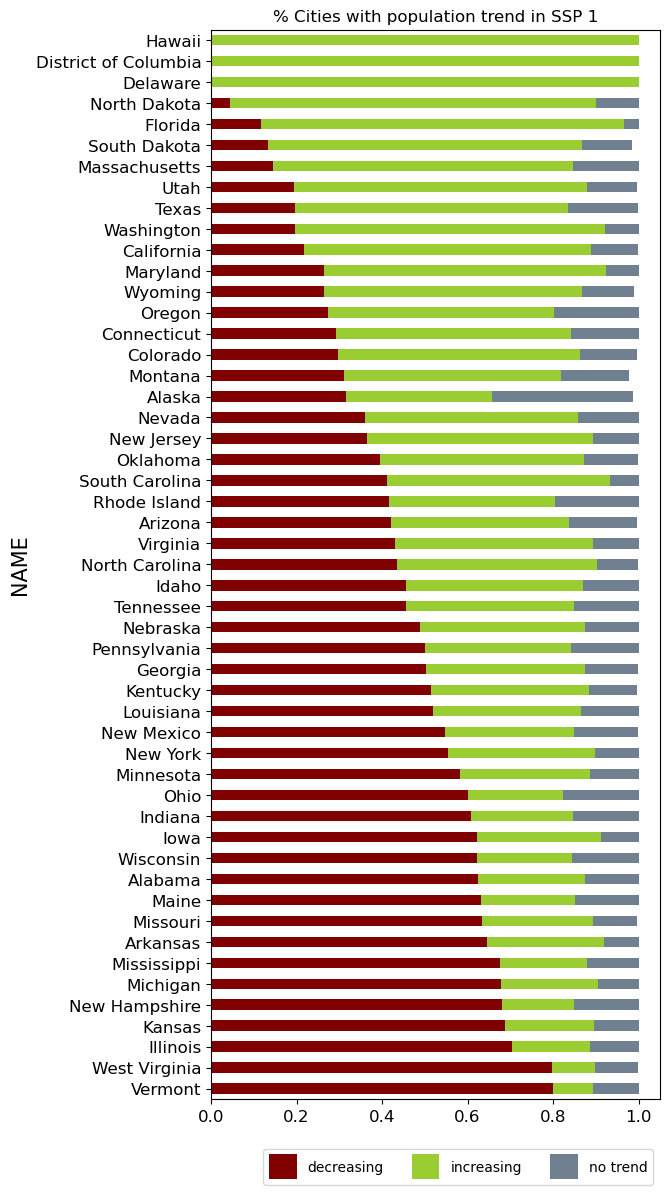

In [161]:
# get state names
state_names= US_states[['STATEFP', 'NAME']]
# Percent cities in each trend group
# pd.set_option('display.max_rows', None)

column_name = 'future trend from SSP 1'

percent_cities = (df.groupby(['STATEFP', column_name]).count()[['GEOID']] /
                  df.groupby(['STATEFP']).count()[['GEOID']]).reset_index()

table = pd.pivot_table(percent_cities, values='GEOID', index=['STATEFP'], # 'future trend from SSP 3'
                    columns=[column_name], aggfunc=np.sum).reset_index()

table = table.merge(state_names, on = 'STATEFP')
# table['sum'] = table[['1 severely depopulating', '2 moderately depopulating','3 slowly depopulating']].sum(axis =1)
table = table.sort_values('decreasing', ascending = False) 
table.drop(columns = ['STATEFP',], inplace = True)

colors = ['maroon','yellowgreen','slategray']
# colors = ['red', 'maroon', 'indianred', 'darkorange', 'limegreen','forestgreen', 'darkgreen', 'gray']
cmap=matplotlib.colors.ListedColormap(colors)

# plot a Stacked Bar Chart using matplotlib
ax = table.plot(
    x = 'NAME',
    kind = 'barh',
    stacked = True,
    cmap = cmap,
    title = '% Cities with population trend in SSP 1',
    mark_right = True,
    figsize=(6.8, 12))
# setting label sizes after creation
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.legend(bbox_to_anchor=(1.01, 1.00), loc='upper left', prop={'size': 15})
ax.legend(bbox_to_anchor=(1.0, -0.04), loc='best', prop={'size': 10},  ncol=3, handleheight=2.4, labelspacing=0.05)
ax.title.set_size(12)
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(r'D:\Work\Box Sync\NC Figures\pct cities with pop trend_' + str(column_name) + '.png',
            dpi = 300)

In [162]:
US_states.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266296765,489206049,+38.6472854,-080.6183274,"POLYGON ((1561561.458 -483489.278, 1561609.307..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138958484319,45975808217,+28.3989775,-082.5143005,"MULTIPOLYGON (((1310991.956 -1534801.808, 1310..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143778461053,6216594318,+40.1028754,-089.1526108,"POLYGON ((742577.181 -445241.678, 743372.372 -..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206232157570,18949864226,+46.3159573,-094.1996043,"POLYGON ((245507.090 186209.715, 245510.348 18..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151895765,6979171386,+38.9466584,-076.6744939,"POLYGON ((1914684.305 -379454.615, 1914689.752..."


In [163]:
# table[table['decreasing'] > 0.50].reset_index()
print('States with 50% or above no of cities with a decreasing trend for: ')

table[table['decreasing'] >0.5]['decreasing'].count()/ table['decreasing'].count()

States with 50% or above no of cities with a decreasing trend for: 


0.4375

In [164]:
(df.groupby(['label'])['NAME'].count()*100/df.groupby(['label'])['NAME'].count().sum()).round(1)

label
1 severely depopulating       0.7
2 moderately depopulating    18.8
3 slowly depopulating        23.6
4 fluctuating                17.0
5 slowly increasing          22.7
6 moderately increasing      14.9
7 highly increasing           2.4
Name: NAME, dtype: float64

In [165]:
df.groupby(['future trend from SSP 1']).size()

future trend from SSP 1
decreasing    14356
increasing    13317
no trend       3895
dtype: int64

In [166]:
df['future trend from SSP 2'].value_counts().sum()

31568

In [167]:
(df.groupby(['label', 'future trend from SSP 4'])['NAME'].count()*100/df.groupby(['label'])['NAME'].count()).round(1)

label                      future trend from SSP 4
1 severely depopulating    decreasing                 72.3
                           increasing                 11.3
                           no trend                   16.4
2 moderately depopulating  decreasing                 84.2
                           increasing                  7.6
                           no trend                    8.2
3 slowly depopulating      decreasing                 78.5
                           increasing                  9.0
                           no trend                   12.5
4 fluctuating              decreasing                 67.8
                           increasing                 14.3
                           no trend                   18.0
5 slowly increasing        decreasing                 48.0
                           increasing                 23.4
                           no trend                   28.6
6 moderately increasing    decreasing                 32.7
     

In [168]:
(df.groupby(['label', 'future trend from SSP 4'])['NAME'].count()*100/df.groupby(['label', 'future trend from SSP 2'])['NAME'].count().sum()).round(1).to_frame()

NAME
label                     future trend from SSP 4      
1 severely depopulating   decreasing                0.5
                          increasing                0.1
                          no trend                  0.1
2 moderately depopulating decreasing               15.9
                          increasing                1.4
                          no trend                  1.5
3 slowly depopulating     decreasing               18.5
                          increasing                2.1
                          no trend                  3.0
4 fluctuating             decreasing               11.5
                          increasing                2.4
                          no trend                  3.1
5 slowly increasing       decreasing               10.9
                          increasing                5.3
                          no trend                  6.5
6 moderately increasing   decreasing                4.9
                          increasing                6.4
                          no trend                  3.6
7 highly increasing       decreasing                0.7
                          increasing                1.2
                          no trend                  0.4

In [169]:
(df.groupby(['future trend from SSP 1','label',])['NAME'].count()*100/df.groupby(['label'])['NAME'].count()).round(1)

future trend from SSP 1  label                    
decreasing               1 severely depopulating      49.7
                         2 moderately depopulating    68.8
                         3 slowly depopulating        60.7
                         4 fluctuating                47.1
                         5 slowly increasing          27.3
                         6 moderately increasing      16.5
                         7 highly increasing          15.1
increasing               1 severely depopulating      29.6
                         2 moderately depopulating    20.1
                         3 slowly depopulating        26.9
                         4 fluctuating                39.2
                         5 slowly increasing          59.5
                         6 moderately increasing      72.5
                         7 highly increasing          75.8
no trend                 1 severely depopulating      20.8
                         2 moderately depopulating    11.1
     

In [170]:
(df.groupby(['future trend from SSP 2','label',]).size()*100/df.groupby(['future trend from SSP 1','label',]).size().sum()).round(1)

future trend from SSP 2  label                    
decreasing               1 severely depopulating       0.3
                         2 moderately depopulating    13.5
                         3 slowly depopulating        15.1
                         4 fluctuating                 8.6
                         5 slowly increasing           6.9
                         6 moderately increasing       2.9
                         7 highly increasing           0.4
increasing               1 severely depopulating       0.2
                         2 moderately depopulating     3.8
                         3 slowly depopulating         6.3
                         4 fluctuating                 6.5
                         5 slowly increasing          13.2
                         6 moderately increasing      10.6
                         7 highly increasing           1.8
no trend                 1 severely depopulating       0.1
                         2 moderately depopulating     1.6
     

# Regional variation of density

In [171]:
# Region 1: Northeast, Region 2: Midwest, Region 3: South, Region 4: West source: wiki
df = df.merge(US_states[['REGION', 'DIVISION', 'STATEFP']], on = 'STATEFP')

In [172]:
df['STATEFP'].unique(), df['REGION'].unique()

(array(['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13',
        '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
        '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
        '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48',
        '49', '50', '51', '53', '54', '55', '56'], dtype=object),
 array(['3', '4', '1', '2'], dtype=object))

In [173]:
df.groupby(['REGION','future trend from SSP 2'])['density_km2'].describe()

count         mean          std       min  \
REGION future trend from SSP 2                                               
1      decreasing               2513.0   479.749693   522.696232  3.458897   
       increasing               1798.0  1309.505418  1616.344547  1.365161   
       no trend                  505.0   767.743270   653.902895  1.944113   
2      decreasing               6254.0   315.753998   285.071854  0.764053   
       increasing               2986.0   533.751289   547.974721  0.203625   
       no trend                  969.0   441.518184   430.575844  0.145928   
3      decreasing               4598.0   189.808183   184.707474  0.923130   
       increasing               4950.0   632.708945   877.691755  0.520646   
       no trend                  948.0   286.250689   346.024748  1.861159   
4      decreasing               1967.0   148.909133   208.304267  0.003233   
       increasing               3317.0   747.749767  1020.154824  0.019661   
       no trend                  763.0   295.588592   514.848711  0.004819   

                                       25%         50%          75%  \
REGION future trend from SSP 2                                        
1      decreasing               140.289742  287.480070   630.837305   
       increasing               418.604279  863.948105  1618.773059   
       no trend                 268.421203  572.611315  1113.963414   
2      decreasing               118.740131  257.765565   437.354027   
       increasing               163.065908  389.622866   701.013422   
       no trend                 147.844289  343.431195   602.209177   
3      decreasing                58.708468  134.541819   263.878906   
       increasing               168.498242  388.341381   786.646279   
       no trend                  89.461780  187.962771   363.226838   
4      decreasing                18.884705   61.522007   199.792497   
       increasing                88.814450  363.010143  1071.965329   
       no trend                  25.648356  106.757319   359.455146   

                                         max  
REGION future trend from SSP 2                
1      decreasing                4103.695866  
       increasing               24038.519242  
       no trend                  4186.021005  
2      decreasing                5142.168139  
       increasing                5661.310260  
       no trend                  5253.099519  
3      decreasing                2313.601185  
       increasing               35050.548646  
       no trend                  4317.384001  
4      decreasing                2272.037114  
       increasing               10856.805045  
       no trend                  5119.891813

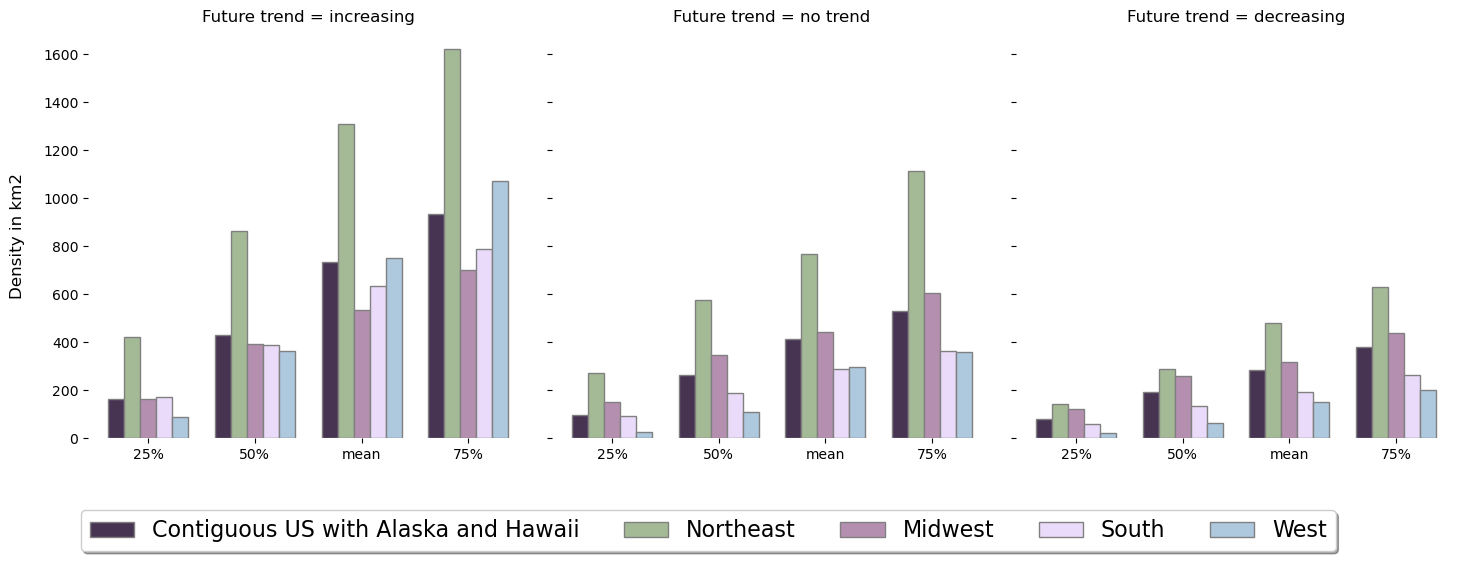

In [174]:
trend_types = ['increasing', 'no trend', 'decreasing']

df_0999 = df.groupby(['REGION','future trend from SSP 2'])['density_km2'].describe()[['25%', '50%','mean', '75%', 'max']].reset_index()
df_mainland = df.groupby(['future trend from SSP 2'])['density_km2'].describe()[['25%', '50%','mean', '75%', 'max']].reset_index()

    
fig, axes = plt.subplots(nrows=1, ncols=3, sharex='col', sharey='row', figsize=(15, 5))

for ax, trend_type in zip(axes.flatten(), trend_types):

    df_plot = pd.concat([df_0999[df_0999['future trend from SSP 2'] == trend_type], 
                    df_mainland[df_mainland['future trend from SSP 2'] == trend_type]], 
                    ignore_index = True)

    df_plot['REGION'] = df_plot['REGION'].replace({'1':'Northeast',
                                               '2':'Midwest',
                                               '3':'South',
                                               '4':'West',
                                               np.nan:'Contiguous US with Alaska and Hawaii'})


    NE = df_plot[df_plot['REGION'] =='Northeast'][['25%', '50%', 'mean', '75%']].values[0]   #[1350,425,884,1702,]
    MW = df_plot[df_plot['REGION'] =='Midwest'][['25%', '50%', 'mean', '75%']].values[0]    #[527,158,380,687,]
    S =  df_plot[df_plot['REGION'] =='South'][['25%', '50%', 'mean', '75%']].values[0]    #[636,164,389,804,]
    W =  df_plot[df_plot['REGION'] =='West'][['25%', '50%', 'mean', '75%']].values[0]    #[747,88,360,1068,]
    MS = df_plot[df_plot['REGION'] =='Contiguous US with Alaska and Hawaii'][['25%', '50%', 'mean', '75%']].values[0]   #[735,158,426,936,]

    n=len(MS)
    r = np.arange(n)
    width = .15

    ax.bar(r, MS, color = '#473452', width = width, edgecolor = 'gray', label='Contiguous US with Alaska and Hawaii',)
    ax.bar(r + width, NE, color = '#a4b996',  width = width, edgecolor = 'gray', label='Northeast',)
    ax.bar(r + 2*width, MW, color = '#b58fb0',  width = width, edgecolor = 'gray', label='Midwest',)
    ax.bar(r + 3*width, S, color = '#e9dbf9',  width = width, edgecolor = 'gray', label='South',)
    ax.bar(r + 4*width, W, color = '#aec8de',  width = width, edgecolor = 'gray', label='West',)
    
    ax.set_title("Future trend = " + str(trend_type))
    ax.set_xticks(r + 2*width,['25%','50%','mean','75%'])
    ax.set_frame_on(False)

fig.supylabel('Density in km2')
plt.rcParams['font.size'] = 16
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(-0.7, -0.15),
          fancybox=True, shadow=True, ncol=5)

plt.show()
fig.savefig(r'D:\Work\Box Sync\NC Figures\density_variation' + '.png', dpi = 300,
           bbox_inches='tight')

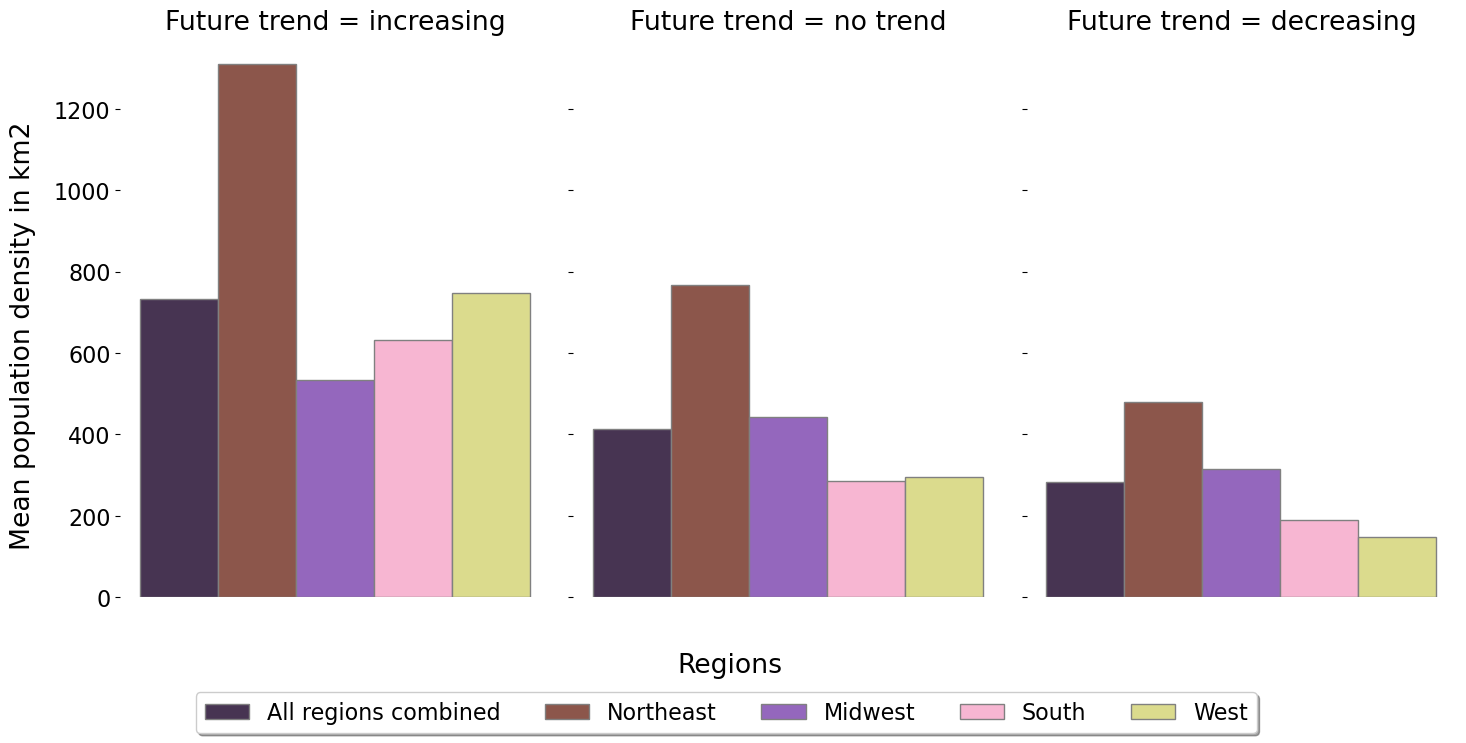

In [175]:
trend_types = ['increasing', 'no trend', 'decreasing']

df_0999 = df.groupby(['REGION','future trend from SSP 2'])['density_km2'].describe()[['25%', '50%','mean', '75%', 'max']].reset_index()
df_mainland = df.groupby(['future trend from SSP 2'])['density_km2'].describe()[['25%', '50%','mean', '75%', 'max']].reset_index()

    
fig, axes = plt.subplots(nrows=1, ncols=3, sharex='col', sharey='row', figsize=(15, 7))

for ax, trend_type in zip(axes.flatten(), trend_types):

    df_plot = pd.concat([df_0999[df_0999['future trend from SSP 2'] == trend_type], 
                    df_mainland[df_mainland['future trend from SSP 2'] == trend_type]], 
                    ignore_index = True)

    df_plot['REGION'] = df_plot['REGION'].replace({'1':'Northeast',
                                               '2':'Midwest',
                                               '3':'South',
                                               '4':'West',
                                               np.nan:'All regions combined'}) # Contiguous US with Alaska and Hawaii


    NE = df_plot[df_plot['REGION'] =='Northeast'][['mean']].values[0]   #[1350,425,884,1702,]
    MW = df_plot[df_plot['REGION'] =='Midwest'][['mean']].values[0]    #[527,158,380,687,]
    S =  df_plot[df_plot['REGION'] =='South'][['mean']].values[0]    #[636,164,389,804,]
    W =  df_plot[df_plot['REGION'] =='West'][['mean']].values[0]    #[747,88,360,1068,]
    MS = df_plot[df_plot['REGION'] == 'All regions combined'][['mean']].values[0]   #[735,158,426,936,]

    n=len(MS)
    r = np.arange(n)
    width = .05

   
    ax.bar(r, MS, color = '#473452', width = width, edgecolor = 'gray', label='All regions combined',)
    ax.bar(r + width, NE, color = '#8C564B',  width = width, edgecolor = 'gray', label='Northeast',)
    ax.bar(r + 2*width, MW, color = '#9467BD',  width = width, edgecolor = 'gray', label='Midwest',)
    ax.bar(r + 3*width, S, color = '#F7B6D2',  width = width, edgecolor = 'gray', label='South',)
    ax.bar(r + 4*width, W, color = '#DBDB8D',  width = width, edgecolor = 'gray', label='West',)
    
    ax.set_title("Future trend = " + str(trend_type))
    ax.set_xticks([]) #r + 2*width,['Regions'])
    ax.set_frame_on(False)

fig.supylabel('Mean population density in km2')
fig.supxlabel('Regions')

plt.rcParams['font.size'] = 16
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(-0.7, -0.15),
          fancybox=True, shadow=True, ncol=5)

plt.show()
fig.savefig(r'D:\Work\Box Sync\NC Figures\density_variation' + '.png', dpi = 300,
           bbox_inches='tight')

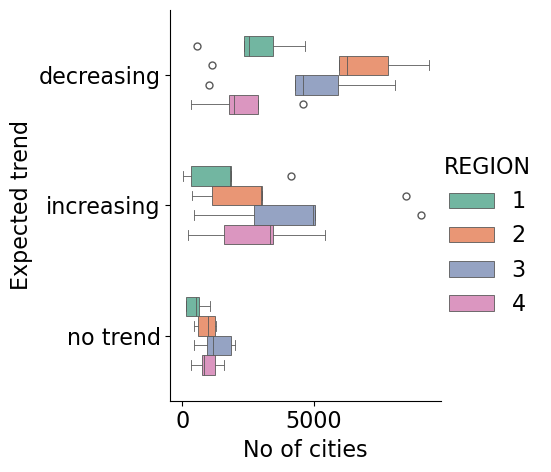

In [176]:
trend_sce_df = pd.DataFrame()
trend_sce_df['SSP 1'] = df.groupby('REGION')['future trend from SSP 1'].value_counts()
trend_sce_df['SSP 2'] = df.groupby('REGION')['future trend from SSP 2'].value_counts()
trend_sce_df['SSP 3'] = df.groupby('REGION')['future trend from SSP 3'].value_counts()
trend_sce_df['SSP 4'] = df.groupby('REGION')['future trend from SSP 4'].value_counts()
trend_sce_df['SSP 5'] = df.groupby('REGION')['future trend from SSP 5'].value_counts()
data = pd.melt(trend_sce_df, value_name='No of cities', col_level=None, ignore_index=False).reset_index()
data.rename({"future trend from SSP 1": 'Expected trend'}, axis = 1, inplace = True)

import seaborn as sns
sns.catplot(x="No of cities", y='Expected trend', 
            data=data,
            palette =sns.set_palette('Set2'),
            kind = 'box',
            hue = 'REGION',
            width = 0.6,
            # saturation=0.5,
            linewidth=0.6,
           )

In [177]:
pd.set_option('display.max_rows', 10)
plot_trend_change = df.groupby(['REGION', 'future trend from SSP 2', 'label'])['density_km2'].describe().round(2).reset_index() #count()

In [178]:
# sns.catplot(x=plot_trend_change.index, y="mean", kind="box", data=plot_trend_change, col="REGION", hue = 'label');

In [179]:
# sns.catplot(data = plot_trend_change, y = 'future trend from SSP 2', x = 'mean',  col="REGION", hue = 'label', kind='swarm')

In [180]:
pd.set_option('display.max_rows', 50)
df[df['density_km2'] != 0].groupby(['REGION','label'])['density_km2'].describe().round(2)

count     mean      std    min     25%  \
REGION label                                                                
1      1 severely depopulating       7.0   424.08   518.16   1.37    6.34   
       2 moderately depopulating   349.0   459.11   457.48   5.89  172.00   
       3 slowly depopulating      1007.0   755.98   652.46   3.79  268.50   
       4 fluctuating               645.0   878.99   864.47   9.32  273.00   
       5 slowly increasing         956.0  1402.71  1739.01  27.76  453.68   
       6 moderately increasing     351.0  1182.84  1819.72   3.51  282.22   
       7 highly increasing          48.0   617.35  1281.08   8.49  143.05   
2      1 severely depopulating      57.0    75.74   109.80   0.38   20.69   
       2 moderately depopulating  1951.0   255.50   265.18   0.15   92.13   
       3 slowly depopulating      2525.0   421.77   377.56   0.40  201.74   
       4 fluctuating              1668.0   450.15   432.58   3.65  188.88   
       5 slowly increasing        1746.0   582.20   488.31   5.15  286.83   
       6 moderately increasing     743.0   505.70   461.51   3.76  227.49   
       7 highly increasing         104.0   364.05   301.38   1.47  153.49   
3      1 severely depopulating      54.0   219.51   429.21   1.39   14.57   
       2 moderately depopulating  1803.0   222.35   264.26   2.06   72.83   
       3 slowly depopulating      1604.0   358.24   435.92   0.52  122.70   
       4 fluctuating              1194.0   423.31   570.71   0.92  120.69   
       5 slowly increasing        1609.0   574.43   656.87   4.84  170.41   
       6 moderately increasing    1506.0   619.11   695.74   4.55  207.13   
       7 highly increasing         282.0   472.63   460.90   3.06  150.61   
4      1 severely depopulating      41.0    27.50    67.67   0.01    0.36   
       2 moderately depopulating   462.0   230.89   739.07   0.02   13.91   
       3 slowly depopulating       572.0   548.33  1109.96   0.03   42.89   
       4 fluctuating               617.0   467.73   754.52   0.00   63.43   
       5 slowly increasing        1189.0   852.08   994.16   0.02  163.06   
       6 moderately increasing    1011.0   682.55   735.37   0.61  118.47   
       7 highly increasing         136.0   442.82   612.61   0.03   20.65   

                                     50%      75%       max  
REGION label                                                 
1      1 severely depopulating     97.81   808.63   1239.48  
       2 moderately depopulating  293.96   582.98   2650.51  
       3 slowly depopulating      590.34  1042.98   4186.02  
       4 fluctuating              606.57  1215.18   6910.87  
       5 slowly increasing        967.88  1747.64  24038.52  
       6 moderately increasing    609.44  1313.80  18659.18  
       7 highly increasing        333.09   650.69   8704.41  
2      1 severely depopulating     46.01    77.58    738.05  
       2 moderately depopulating  190.78   331.51   2835.93  
       3 slowly depopulating      347.26   531.92   5142.17  
       4 fluctuating              357.65   567.64   5613.28  
       5 slowly increasing        471.29   716.46   5661.31  
       6 moderately increasing    410.17   687.02   5253.10  
       7 highly increasing        294.11   486.91   1267.64  
3      1 severely depopulating     56.98   175.71   2313.60  
       2 moderately depopulating  152.34   278.63   3636.46  
       3 slowly depopulating      247.59   427.74   4317.38  
       4 fluctuating              251.83   469.82   5755.05  
       5 slowly increasing        359.08   728.61   7816.00  
       6 moderately increasing    416.21   757.89   8520.33  
       7 highly increasing        377.05   642.21   3480.67  
4      1 severely depopulating      3.26    25.34    409.26  
       2 moderately depopulating   63.79   237.11  10856.81  
       3 slowly depopulating      199.42   493.29   8283.40  
       4 fluctuating              239.73   503.39   6819.43  
       5 slowly increasing        497.94  1199.31 

In [181]:
pd.set_option('display.max_rows', 50)
df[df['density_km2'] != 0].groupby(['REGION', 'future trend from SSP 4', ])['density_km2'].describe().round(2)

count     mean      std    min     25%  \
REGION future trend from SSP 4                                            
1      decreasing               3438.0   572.79   625.46   1.37  163.81   
       increasing                333.0  1979.85  2676.96  21.27  679.15   
       no trend                 1045.0  1262.47  1288.52  14.27  439.22   
2      decreasing               7816.0   334.44   311.32   0.15  122.52   
       increasing               1122.0   450.14   447.94   1.00  122.26   
       no trend                 1271.0   690.22   662.61   0.38  244.89   
3      decreasing               5924.0   204.06   204.78   0.92   62.69   
       increasing               2710.0   750.70  1046.93   0.52  215.18   
       no trend                 1862.0   554.65   631.96   0.64  151.87   
4      decreasing               2889.0   181.63   282.00   0.00   21.34   
       increasing               1564.0   720.65   903.14   0.02  105.93   
       no trend                 1594.0   844.97  1162.57   0.00   86.70   

                                    50%      75%       max  
REGION future trend from SSP 4                              
1      decreasing                348.29   775.28   8704.41  
       increasing               1297.21  2297.42  24038.52  
       no trend                  849.00  1629.86  12333.73  
2      decreasing                268.37   457.08   5253.10  
       increasing                329.24   644.21   4959.73  
       no trend                  508.77   894.20   5661.31  
3      decreasing                143.85   282.45   4317.38  
       increasing                496.40   954.10  35050.55  
       no trend                  340.23   690.24   5755.05  
4      decreasing                 70.82   240.76   3972.55  
       increasing                386.80  1111.70  10856.81  
       no trend                  388.79  1171.87   8402.91

In [182]:
(df[['future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 
    'future trend from SSP 4', 'future trend from SSP 5']].apply(pd.Series.value_counts)/df[['future trend from SSP 1', 'future trend from SSP 2', 
    'future trend from SSP 3', 'future trend from SSP 4','future trend from SSP 5']].apply(pd.Series.value_counts).sum()).round(2)

,future trend from SSP 1,future trend from SSP 2,future trend from SSP 3,future trend from SSP 4,future trend from SSP 5
decreasing,0.45,0.49,0.85,0.64,0.09
increasing,0.42,0.41,0.03,0.18,0.86
no trend,0.12,0.10,0.12,0.18,0.05


# Export forecasted trend


In [184]:
df[['STATEFP', 'GEOID', 'NAMELSAD', 'CensusPop_20','label', 'State',  
    'future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 'future trend from SSP 4', 'future trend from SSP 5', 'REGION', 
    'DIVISION']].to_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\future trend from SSP' + '.csv')

# previous path = D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\forecast trend output

# Results for a Single State

In [199]:
df_state = df[df['STATEFP']== '31']
df_state.shape

(590, 86)

In [200]:
(df_state[['future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 
    'future trend from SSP 4', 'future trend from SSP 5']].apply(pd.Series.value_counts)/df_state[['future trend from SSP 1', 'future trend from SSP 2', 
    'future trend from SSP 3', 'future trend from SSP 4','future trend from SSP 5']].apply(pd.Series.value_counts).sum()).round(2)

,future trend from SSP 1,future trend from SSP 2,future trend from SSP 3,future trend from SSP 4,future trend from SSP 5
decreasing,0.49,0.52,0.88,0.75,0.05
increasing,0.38,0.39,0.07,0.18,0.90
no trend,0.13,0.08,0.05,0.08,0.05


In [201]:
(df_state.groupby(['future trend from SSP 2','label',])['NAME'].count()*100/df_state.groupby(['label'])['NAME'].count()).round(1).to_frame()

NAME
future trend from SSP 2 label                          
decreasing              1 severely depopulating    66.7
                        2 moderately depopulating  58.9
                        3 slowly depopulating      55.1
                        4 fluctuating              57.7
                        5 slowly increasing        41.3
                        6 moderately increasing    31.2
                        7 highly increasing        25.0
increasing              2 moderately depopulating  25.8
                        3 slowly depopulating      37.3
                        4 fluctuating              35.1
                        5 slowly increasing        54.7
                        6 moderately increasing    65.6
                        7 highly increasing        75.0
no trend                1 severely depopulating    33.3
                        2 moderately depopulating  15.2
                        3 slowly depopulating       7.6
                        4 fluctuating               7.2
                        5 slowly increasing         4.0
                        6 moderately increasing     3.1

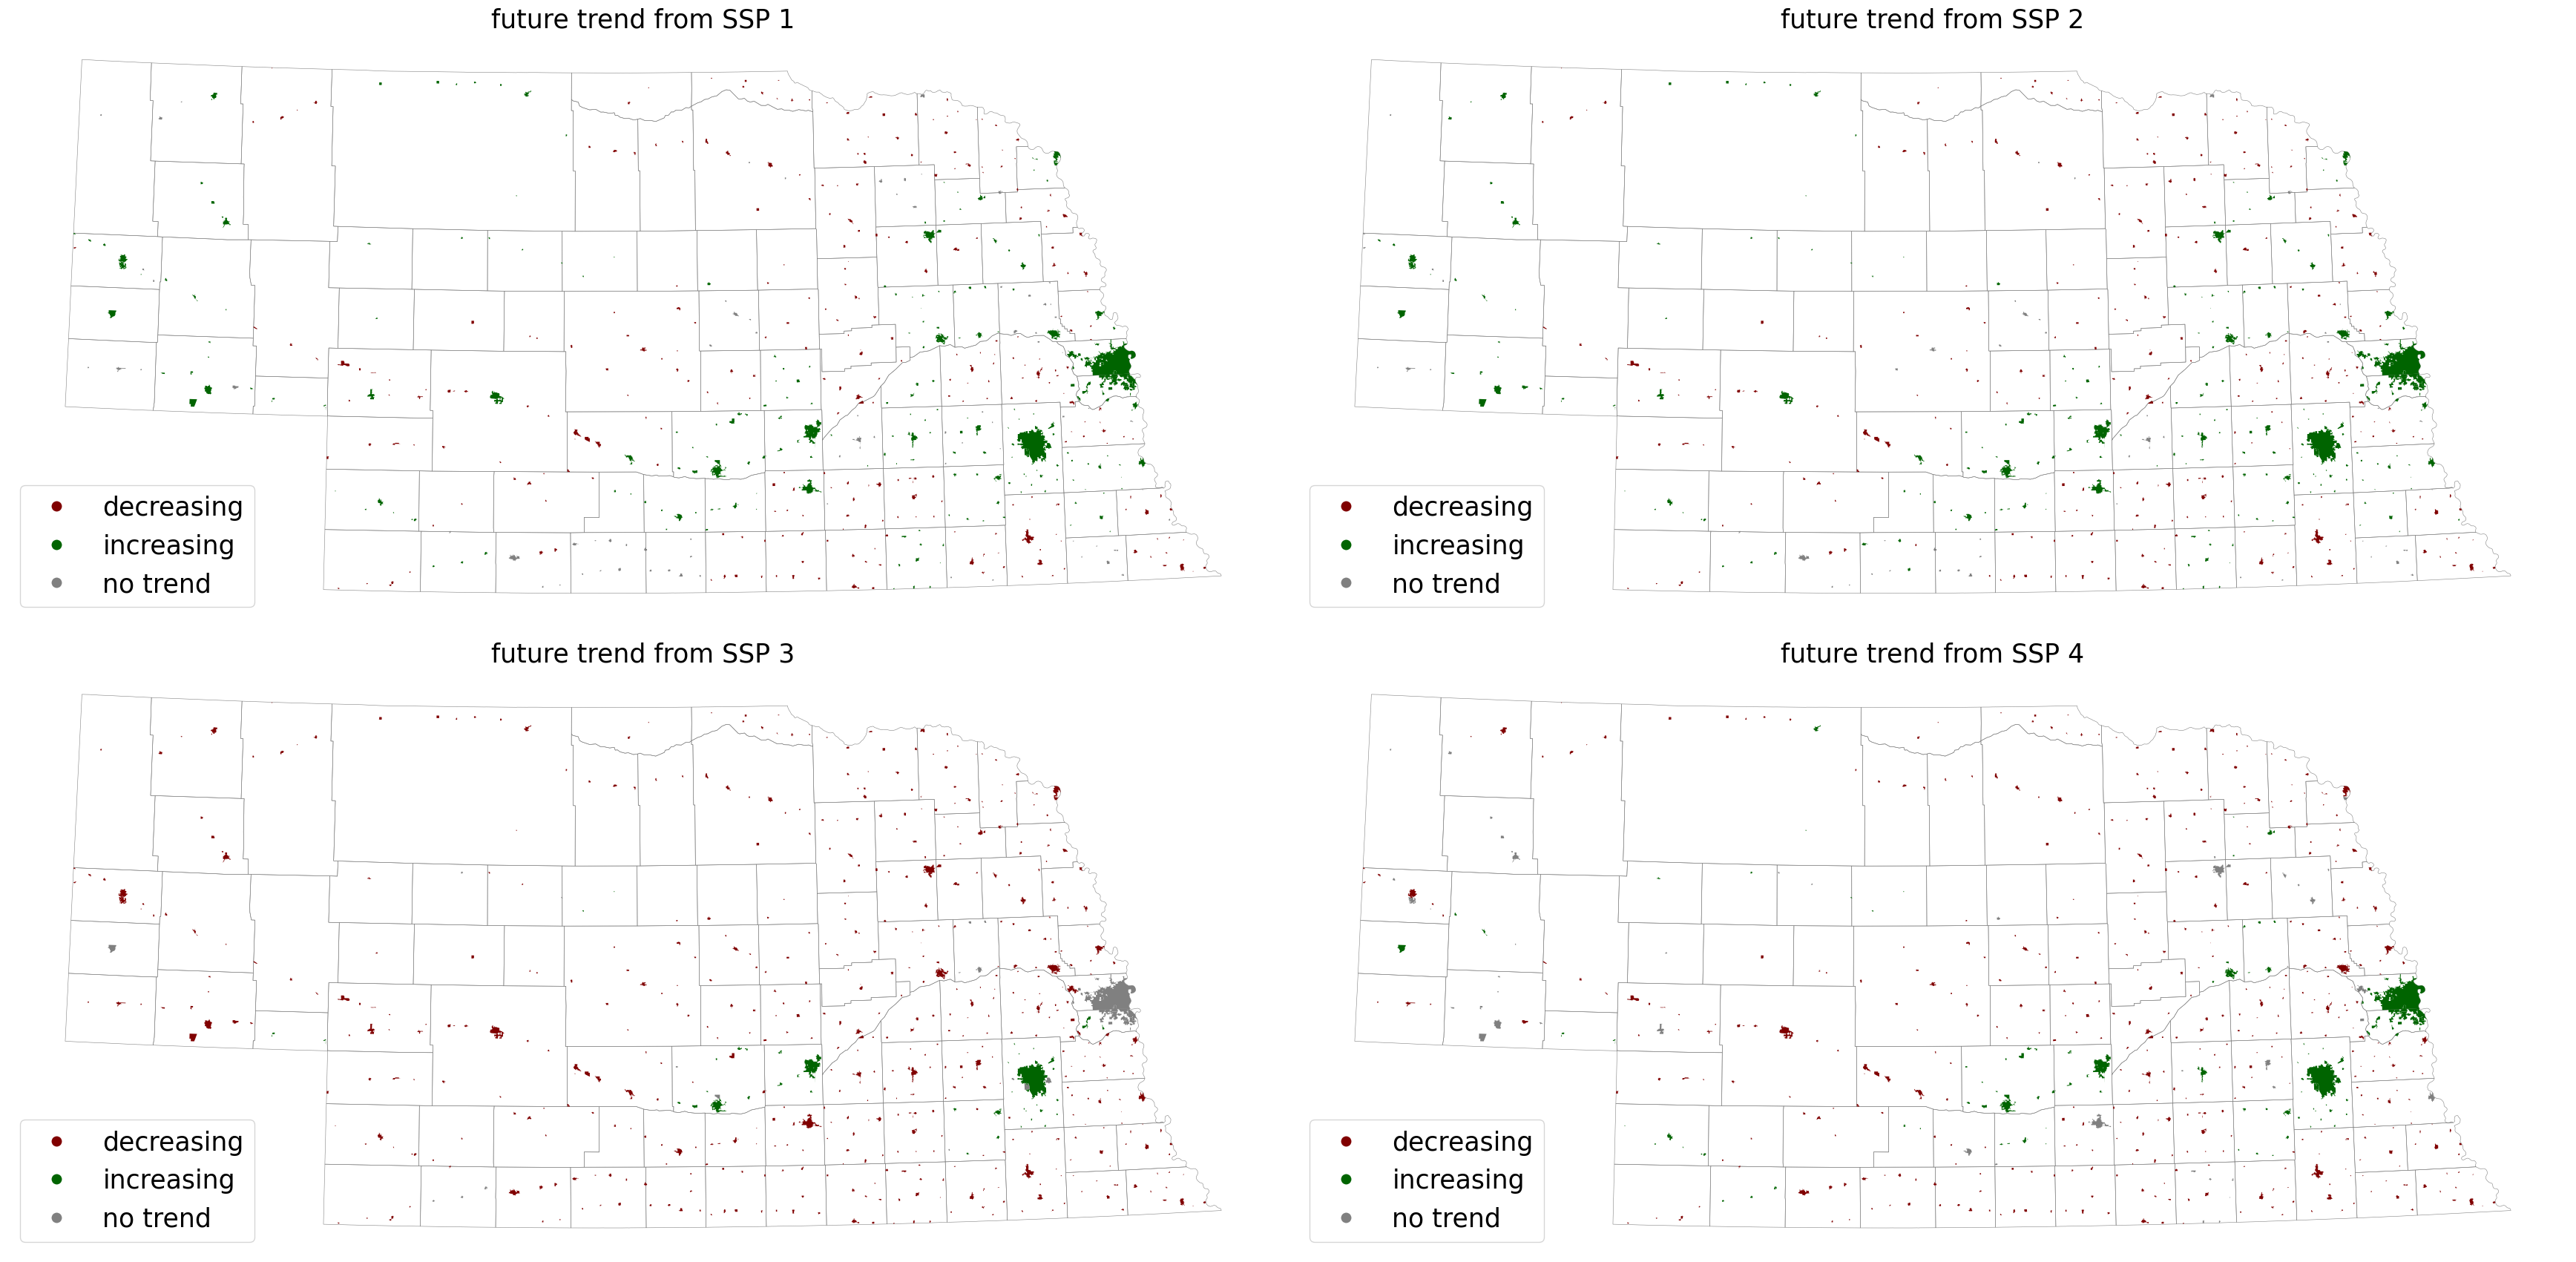

In [202]:
# set state code as index, exclude states that we will never display
gdf = df_state.to_crs('epsg:9311') 
counties_IL = US_counties_cb[US_counties_cb['STATEFP'] == '31'].to_crs('epsg:9311') 

#.drop(index=['02', 'VI', 'MP', 'GU', 'AS'])
colors = ['maroon','darkgreen','gray']

column_name = ["future trend from SSP 1", "future trend from SSP 2","future trend from SSP 3", "future trend from SSP 4"]
# x_labels = {"future trend from SSP 2": "(a)", 
#             "future trend from SSP 4": '(b)'}


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(35, 20))

for ax, col in zip(axes.flatten(), column_name):
    counties_IL.plot(ax=ax, facecolor = 'none', edgecolor='gray', linewidth=0.4)
    gdf.plot(column=col, 
             ax=ax,
             cmap=matplotlib.colors.ListedColormap(colors), 
             legend = True,
             legend_kwds={'loc': 'lower left', 'fontsize': 25,})
    
    ax.set_title(col, fontdict={'fontsize': 25, 'fontweight': 'medium'})


    # remove ticks
    for ax in axes.flatten():
        ax.set_yticks([])
        ax.set_xticks([])
        ax.axis('off')
        plt.tight_layout()
        plt.axis('off') 
    
        
# fig.patch.set_visible(False)

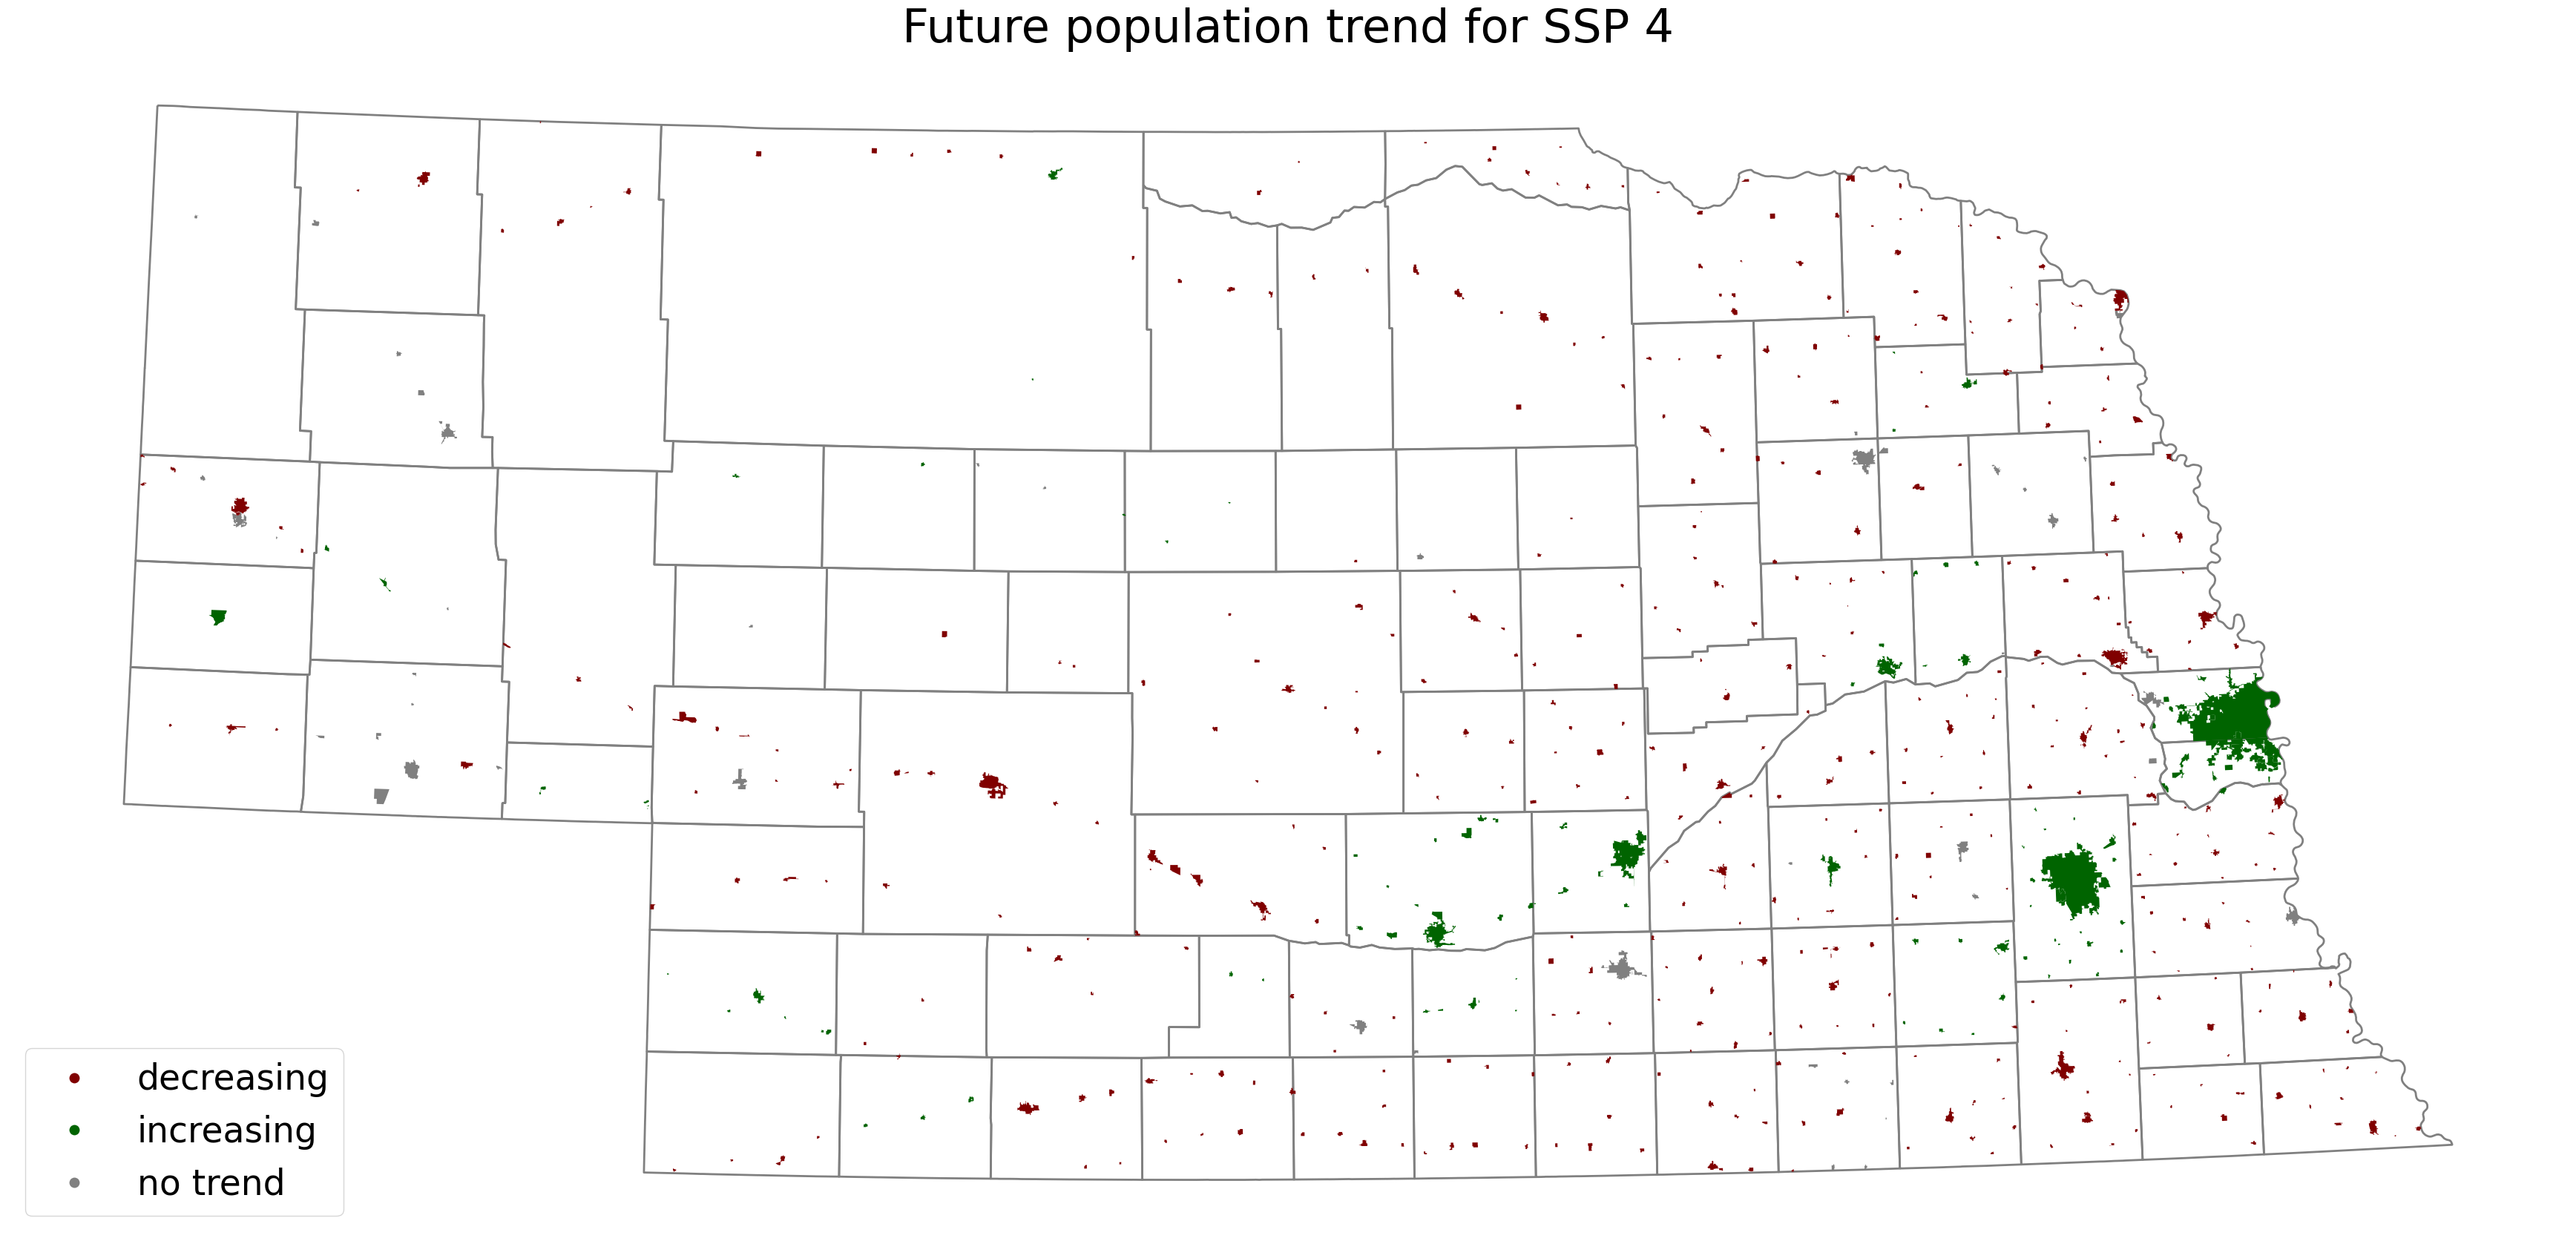

In [203]:


colors = ['maroon','darkgreen','gray']

column_name = ["future trend from SSP 4"]
# x_labels = {"future trend from SSP 2": "(a)", 
#             "future trend from SSP 4": '(b)'}


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(35, 20))

counties_IL.plot(ax=ax, facecolor = 'none', edgecolor='grey', linewidth=2)
gdf.plot(column=col, 
             ax=ax,
             cmap=matplotlib.colors.ListedColormap(colors), 
             legend = True,
             legend_kwds={'loc': 'lower left', 'fontsize': 34,})
    
ax.set_title("Future population trend for SSP 4", fontdict={'fontsize': 45, 'fontweight': 'medium'})

ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.tight_layout()
plt.axis('off') 
fig.savefig(r'D:\Work\Box Sync\NC Figures\Future_trend_SSP4_31.png', dpi = 300, bbox_inches='tight')

In [204]:
print(gdf.shape, counties_IL.shape)
gpd.sjoin(counties_IL, gdf, predicate='contains').groupby(['GEOID_right']).size()

(590, 86) (93, 13)


GEOID_right
3100205    1
3100240    1
3100380    1
3100415    1
3100555    1
          ..
3153835    1
3153905    1
3154020    1
3154045    1
3154115    1
Length: 559, dtype: int64

In [205]:
gdf.groupby('future trend from SSP 1').size()

future trend from SSP 1
decreasing    289
increasing    227
no trend       74
dtype: int64

In [206]:
df_state[df_state['density_km2'] != 0].groupby(['label'])['density_km2'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
1 severely depopulating,3.0,47.41,12.55,33.53,42.14,50.76,54.35,57.94
2 moderately depopulating,151.0,216.88,140.39,14.58,115.64,177.00,293.32,712.51
3 slowly depopulating,158.0,356.95,177.03,21.10,228.65,344.14,465.72,890.17
4 fluctuating,111.0,362.21,220.04,3.65,187.34,380.10,492.09,1192.34
5 slowly increasing,75.0,545.31,302.11,53.42,342.39,522.35,711.36,1534.45
6 moderately increasing,32.0,626.32,333.91,46.43,361.69,593.40,816.07,1325.65
7 highly increasing,4.0,564.62,538.86,9.05,187.15,524.21,901.68,1200.98


In [207]:
df_state[df_state['density_km2'] != 0].groupby(['future trend from SSP 2'])['density_km2'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
future trend from SSP 2,,,,,,,,
decreasing,307.0,299.71,205.94,3.43,132.25,268.26,419.50,1192.34
increasing,233.0,396.32,299.11,2.03,157.74,356.55,557.82,1534.45
no trend,50.0,264.39,190.73,16.55,104.91,212.15,400.61,712.51


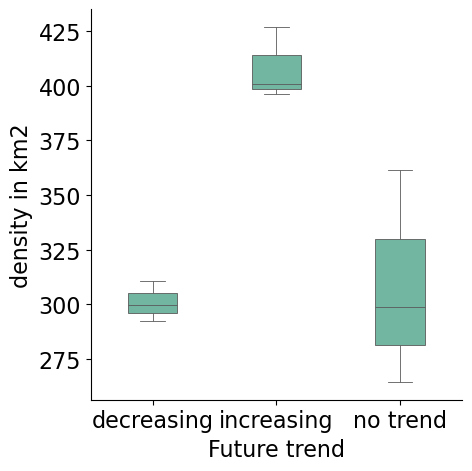

In [208]:
trend_sce_df = pd.DataFrame()
trend_sce_df['SSP 1'] = df_state.groupby('future trend from SSP 1')['density_km2'].mean()
trend_sce_df['SSP 2'] = df_state.groupby('future trend from SSP 2')['density_km2'].mean()
# trend_sce_df['SSP 3'] = df_state.groupby('future trend from SSP 3')['density_km2'].mean()
trend_sce_df['SSP 4'] = df_state.groupby('future trend from SSP 4')['density_km2'].mean()
# trend_sce_df['SSP 5'] = df_state.groupby('future trend from SSP 5')['density_km2'].mean()
data = pd.melt(trend_sce_df, value_name='density in km2', col_level=None, ignore_index=False).reset_index()
data.rename({"future trend from SSP 1": 'Future trend'}, axis = 1, inplace = True)

import seaborn as sns
sns.catplot(y="density in km2", x='Future trend', 
            data=data,
            palette =sns.set_palette('Set2'),
            kind = 'box',
            # hue = 'REGION',
            width = 0.4,
            # saturation=0.5,
            linewidth=0.6,
           )

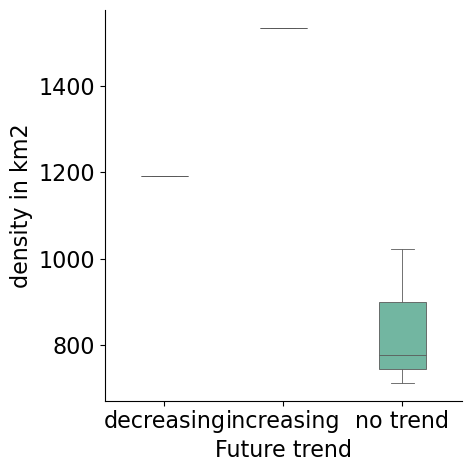

In [209]:
trend_sce_df = pd.DataFrame()
trend_sce_df['SSP 1'] = df_state.groupby('future trend from SSP 1')['density_km2'].max()
trend_sce_df['SSP 2'] = df_state.groupby('future trend from SSP 2')['density_km2'].max()
# trend_sce_df['SSP 3'] = df_state.groupby('future trend from SSP 3')['density_km2'].mean()
trend_sce_df['SSP 4'] = df_state.groupby('future trend from SSP 4')['density_km2'].max()
# trend_sce_df['SSP 5'] = df_state.groupby('future trend from SSP 5')['density_km2'].mean()
data = pd.melt(trend_sce_df, value_name='density in km2', col_level=None, ignore_index=False).reset_index()
data.rename({"future trend from SSP 1": 'Future trend'}, axis = 1, inplace = True)

import seaborn as sns
sns.catplot(y="density in km2", x='Future trend', 
            data=data,
            palette =sns.set_palette('Set2'),
            kind = 'box',
            # hue = 'REGION',
            width = 0.4,
            # saturation=0.5,
            linewidth=0.6,
           )
